#Deep Parametric PDE

In [ ]:
# importing libraries
import numpy as np
import tensorflow as tf
import cupy as cp
import cupyx as cpx

from tensorflow import keras
from scipy.stats import norm
from numpy.polynomial.hermite import hermgauss

import matplotlib.pyplot as plt
from torch import autograd

import urllib
import os
import torch
import torch.nn.functional as F
from torch import nn, Tensor
import numpy as np
from torch.nn import Module, Linear, BatchNorm1d, Tanh
from numba import cuda
np.random.seed(42)
import itertools

In [ ]:
import math
from scipy import optimize

"""
Implementing Newton-Raphson method for calculating implied volatility
"""

def calculate_option_price(S, K, r, T, sigma):
    """
    Calculates the price of a European call option using the Black-Scholes formula.
    """
    d1 = (math.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)

def calculate_implied_volatility(S, K, r, T, option_price):
    """
    Calculates the implied volatility of an option using the Newton-Raphson method.
    """
    # Define the function whose root we want to find (Black-Scholes equation)
    def black_scholes(sigma):
        return calculate_option_price(S, K, r, T, sigma) - option_price

    # Use the Newton-Raphson method to find the root (implied volatility)
    implied_volatility = optimize.newton(black_scholes, x0=0.5)

    return implied_volatility


In [ ]:
def basket_option_montecalro(t,
                             S,
                             CovMatrix,
                             K,
                             r,
                             dim):
   """
    Calculate option price with montecarlo method for evaluation of other methods with Cupy
    Args :
      t (float) :  time to maturity
      S (numpy array) : underling asset price
      CovMatrix (numpy array):  covarince  matrix of returns
      K (float) : Strike price
      r (float) : risk free rate
      dim (int) : number of underlying assets

    Returns:
      price (float) : option price of basket price
    """
  W = cp.random.multivariate_normal(mean = np.zeros(dim) , cov = t*CovMatrix, size = 10000000) # generating random number for sampling of price

  Sn =  cp.array(cp.exp((r- cp.diagonal(CovMatrix)/2)*t + W)) * 100 # sample from stock price in maturity
  payoff = cp.maximum(np.mean(Sn,1 ) - K , 0) # calcualte payoff
  return cp.mean(payoff) * cp.exp(-r * t) # calculate expected value



In [ ]:
def lower_bound(t,
                s,
                K,
                r):
   """
    Compute lower bound of option price as mentioned in paper
    Args :
      t(float): time to maturity
      s(float): stock price
      K(float): strike price
      r(float): risk free rate
    """
  return np.maximum(s- K*np.exp(-r * t), 0 )

In [ ]:
def one_dimensional_exact_solution(t,
                                   s,
                                   riskfree_rate,
                                   volatility,
                                   strike_price):
    """
    Standard Black-Scholes formula

    Args:
      t (flaot) : time to maturity
      s (flaot) : stock price
      riskfree_rate (flaot) : risk free rate
      volatility (float)  : volatiliy of return
      strike_price (float):  strike price

    Returns :
      option price (float)

    """

    d1 = (1 / (volatility*np.sqrt(t))) * (
            np.log(s/strike_price)
            + (riskfree_rate + volatility**2/2.) * t
        )
    d2 = d1 - volatility*np.sqrt(t)
    return (norm.cdf(d1) * s
            - norm.cdf(d2) * strike_price * np.exp(-riskfree_rate*t))

""" Implementing above function with Cupy for more speed """
def one_dimensional_exact_solutiongpu(
        t, s, riskfree_rate, volatility, strike_price):
    """ Standard Black-Scholes formula """

    d1 = (1 / (volatility*cp.sqrt(t))) * (
            cp.log(s/strike_price)
            + (riskfree_rate + volatility**2/2.) * t
        )
    d2 = d1 - volatility*cp.sqrt(t)
    return (cpx.scipy.special.ndtr(d1) * s
            - cpx.scipy.special.ndtr(d2) * strike_price * cp.exp(-riskfree_rate*t))


In [ ]:
def h_ybar(y,V , w):
  """ Calculting of h_ybar as mention in Bayer method """
  return np.dot(w.T,np.exp(np.matmul(V , y)))

In [ ]:
def decompose_covariance_matrix1(t, # time to maturity
                                 CovMatrix # covarince matrix of returns in time 1
                                 ):
  """ Decomposing Covarince matrix as mention in Bayer(2018)

  Args :
    t(float): time to maturity
    CovMatrix (numpy array): covarince matrix of returns in time 1

  Returns :
    V (numpy 2D array) : V in paper
    D (numpy 1D array) : diag of diagonal matrix D
  """
  CovMatrix = np.matrix(t* CovMatrix) # adjust covariance matrix
  v1 = np.ones((np.shape(CovMatrix)[0] , 1)) # crate vector with all entry one
  w = np.linalg.inv(CovMatrix) * v1 # compute w

  covbar = CovMatrix - np.matmul(v1 , v1.T)/(np.dot(v1.T,w)) # compute covarance bar as mentioned in paper
  lamda ,v2 = np.linalg.eig(covbar) # decomse pesitive semi-definite matrix

  # sort eigen value
  idx = lamda.argsort()[::-1]
  lamda = lamda[idx]
  v2 = v2[:,idx]

  V  = np.append(v1, v2[:,:-1], axis=1)

  D = np.append(1/np.dot(v1.T,w)[0,0] ,lamda[:-1])
  return V,D

In [ ]:
def ExactSoloution(t,
                   S0,
                   CovMatrix,
                   K,
                   w1,
                   riskfree_rate):
  """ Calculating exact solution of basket option price by Bayer method and Hermit-Guass quadrature method
  Args :
    t(float) :  time to maturity
    S0 (numpy array)  :  stock prices
    CovMatrix (numpy array) :  covarince matrix of return
    K (float)  : strick price
    w1 (numpy array) : weight in basket optio for calulating payoff
    riskfree_rate(float): risk free rate
  Returns  :
    option price (float)

  """
  if t == 0 :
    return np.maximum(np.dot(w1.T, S0) - K ,0)
  dim = np.shape(CovMatrix)[0] - 1
  weight = w1*S0 * np.exp(-0.5 * np.diagonal(CovMatrix * t).reshape(dim+1,1)) # calculate weight respect to way that mentiond by Bayer(2018)
  dim = np.shape(CovMatrix)[0] - 1
  points , weights = [],[] # points and its weights in Hermit-Gaussian qaudrature
  integration_points, integration_weights = hermgauss(70) # smaple from Hermit-Gaussian
  V,D = decompose_covariance_matrix1(t,CovMatrix) # decompose covariance matrix

  # make list of sample (each sample is for a dimension)
  points.append(integration_points)
  weights.append(integration_weights)
  for i in range(dim - 1):
    integration_points, integration_weights = hermgauss(70)
    points.append(integration_points)
    weights.append(integration_weights)

  #calculate cartesian product of points for calculating integral in more dimension
  points = itertools.product(*points)
  points = np.array([np.array(el) for el in points])
  weights = itertools.product(*weights)


  ww = np.array([np.cumprod(np.array(el))[-1] for el in weights]).reshape(np.shape(points)[0],1) #calculate each point weight

  p = np.array(points).reshape(np.shape(points)[0] , dim)*(np.sqrt(2*D[1:]).reshape(1,dim)) #adjusting
  w = ww / (np.sqrt(np.pi)**(dim)) #adjusting


  h =np.matmul(weight.T, np.exp(np.matmul(V[:,1:] , np.transpose(p, (1, 0))))).T # calculate as mentiond in Bayer(2018)

  # solve option price in  one dimension
  evaluation_at_integration_points = one_dimensional_exact_solution(
        t=1, s=np.array(h) * np.exp(0.5*D[0]),
        strike_price=np.exp(-riskfree_rate * t) * K,
        volatility=np.sqrt(D[0]), riskfree_rate=0.
        )


  sol = np.sum(evaluation_at_integration_points * w)

  return sol


""" In this function because in some case V and D is same for large number of sample so we don't need compute them in  each step so we implemented this function """
def ExactSoloutionEnhanced(t,S0,V,D,CovMatrix,K,w1,riskfree_rate):
  if t == 0 :
    return np.maximum(np.dot(w1.T, S0) - K ,0)
  dim = np.shape(CovMatrix)[0] - 1

  weight = w1*S0 * np.exp(-0.5 * np.diagonal(CovMatrix * t).reshape(dim+1,1))
  dim = np.shape(CovMatrix)[0] - 1
  points , weights = [],[]
  integration_points, integration_weights = hermgauss(20)



  points.append(integration_points)
  weights.append(integration_weights)
  for i in range(dim - 1):
    integration_points, integration_weights = hermgauss(20)
    points.append(integration_points)
    weights.append(integration_weights)

  points = itertools.product(*points)

  points = np.array([np.array(el) for el in points])

  weights = itertools.product(*weights)


  ww = np.array([np.cumprod(np.array(el))[-1] for el in weights]).reshape(np.shape(points)[0],1)

  p = np.array(points).reshape(np.shape(points)[0] , dim)*(np.sqrt(2*D[1:]).reshape(1,dim))
  w = ww / (np.sqrt(np.pi)**(dim))

  h =np.matmul(weight.T, np.exp(np.matmul(V[:,1:] , np.transpose(p, (1, 0))))).T

  evaluation_at_integration_points = one_dimensional_exact_solution(
        t=1, s=np.array(h) * np.exp(0.5*D[0]),
        strike_price=np.exp(-riskfree_rate * t) * K,
        volatility=np.sqrt(D[0]), riskfree_rate=0.
        )


  sol = np.sum(evaluation_at_integration_points * w)

  return sol


""" This function is pervious function but it uses GPU   """
def ExactSoloutionEnhancedgpu(t,S0,V,D,CovMatrix,K,w1,riskfree_rate):
  if t == 0 :
    return np.maximum(np.dot(w1.T, S0) - K ,0)
  dim = cp.shape(CovMatrix)[0] - 1

  weight = w1*S0 * cp.exp(-0.5 * cp.diagonal(CovMatrix * t).reshape(dim+1,1))
  dim = cp.shape(CovMatrix)[0] - 1
  points , weights = [],[]
  integration_points, integration_weights = hermgauss(20)



  points.append(integration_points)
  weights.append(integration_weights)
  for i in range(dim - 1):
    integration_points, integration_weights = hermgauss(20)
    points.append(integration_points)
    weights.append(integration_weights)

  points = itertools.product(*points)

  points = cp.array([cp.array(el) for el in points])

  weights = itertools.product(*weights)


  ww = cp.array([cp.cumprod(np.array(el))[-1] for el in weights]).reshape(cp.shape(points)[0],1)

  p = cp.array(points).reshape(cp.shape(points)[0] , dim)*(cp.sqrt(2*D[1:]).reshape(1,dim))
  w = ww / (cp.sqrt(np.pi)**(dim))

  h =cp.matmul(weight.T, cp.exp(cp.matmul(V[:,1:] , cp.transpose(p, (1, 0))))).T

  evaluation_at_integration_points = one_dimensional_exact_solutiongpu(
        t=1, s=cp.array(h) * cp.exp(0.5*D[0]),
        strike_price=np.exp(-riskfree_rate * t) * K,
        volatility=cp.sqrt(D[0]), riskfree_rate=0.
        )


  sol = cp.sum(evaluation_at_integration_points * w)

  return sol

""" This function is only for sampling points form hermit-guass """"
def getPointsWeights(dim, sampleInEachAxis = 33):

  points , weights = [],[]
  integration_points, integration_weights = hermgauss(sampleInEachAxis)



  points.append(integration_points)
  weights.append(integration_weights)
  for i in range(dim - 1):
    integration_points, integration_weights = hermgauss(sampleInEachAxis)
    points.append(integration_points)
    weights.append(integration_weights)

  points = itertools.product(*points)

  points = np.array([np.array(el) for el in points])

  weights = itertools.product(*weights)


  ww = np.array([np.cumprod(np.array(el))[-1] for el in weights]).reshape(np.shape(points)[0],1)



  return points , ww

"""This fucntion is same as functions in above but it get points and ww for more speed
  in this function we don't need to sample againg so our speed increased
 """
def ExactSoloutionEnhancedgpumore(t,S0,V,D,CovMatrix,K,w1,riskfree_rate ,poitns , ww):
  if t == 0 :
    return np.maximum(np.dot(w1.T, S0) - K ,0)
  dim = cp.shape(CovMatrix)[0] - 1

  weight = w1*S0 * cp.exp(-0.5 * cp.diagonal(CovMatrix * t).reshape(dim+1,1))
  dim = cp.shape(CovMatrix)[0] - 1

  p = cp.array(points).reshape(cp.shape(points)[0] , dim)*(cp.sqrt(2*D[1:]).reshape(1,dim))
  w = ww / (cp.sqrt(np.pi)**(dim))

  h =cp.matmul(weight.T, cp.exp(cp.matmul(V[:,1:] , cp.transpose(p, (1, 0))))).T

  evaluation_at_integration_points = one_dimensional_exact_solutiongpu(
        t=1, s=cp.array(h) * cp.exp(0.5*D[0]),
        strike_price=cp.exp(-riskfree_rate * t) * K,
        volatility=cp.sqrt(D[0]), riskfree_rate=0.
        )


  sol = cp.sum(evaluation_at_integration_points * w)

  return sol

In [ ]:
class NuarlBox(nn.Module):
   """
    Base subnetwork that introduced in DGM.

    Args:
    indim (int): input dimension
    outdim (int) : number of node in hidden layer

    """
  def __init__(self,
              indim=100,
              outdim = 50
              ):
    super().__init__()
    self.acitivision = nn.Tanh()
    self.z = nn.Linear(outdim,outdim,bias=False)
    self.g = nn.Linear(outdim,outdim,bias=False)
    self.r = nn.Linear(outdim,outdim,bias=False)
    self.h = nn.Linear(outdim,outdim,bias=False)
    self.z1 = nn.Linear(outdim,outdim)
    self.g1 = nn.Linear(outdim,outdim)
    self.r1 = nn.Linear(outdim,outdim)
    self.h1 = nn.Linear(outdim,outdim)
    self.s1 = nn.Linear(indim,outdim)
    self.s2 = nn.Linear(indim ,outdim)
    self.s3 = nn.Linear(indim ,outdim)
    self.s4 = nn.Linear(indim ,outdim)







  def forward(self, x,s):

    z1 =self.z(s) + self.s1(x)
    z1 = self.acitivision(z1)
    g1 = self.g(s) + self.s2(x)
    g1 = self.acitivision(g1)
    r1 = self.r(s) + self.s3(x)
    r1 = self.acitivision(r1)
    h1 = self.h(torch.mul(s,r1)) + self.s4(x)
    h1 = self.acitivision(h1)
    s2 = torch.mul((1.0-g1),h1) + torch.mul(z1,s)
    return s2


class DeepParametric(nn.Module):
  """
    Base Model

    Args:
    dim (int): input dimension
    layersize (int) : number of node in hidden layer

    """
  def __init__(self,

              dim=100,
              layersize = 50,
              ):
    super().__init__()


    self.dim = dim
    self.layer1 = nn.Linear(self.dim  , layersize)
    self.module1 = NuarlBox(indim = self.dim ,outdim = layersize)
    self.module2 = NuarlBox(indim = self.dim ,outdim = layersize)
    self.module3 = NuarlBox(indim = self.dim,outdim = layersize)

    self.last_layer = nn.Linear(layersize,1)

    self.acitivision  = nn.Tanh()


  def forward(self,y):

    s1=self.layer1(y)
    s1= self.acitivision(s1)
    s2 = self.module1(y,s1)
    s3 = self.module2(y,s2)
    s4 = self.module3(y,s3)
    out =self.last_layer(s4)
    iterior = y
    """In the below sentences we compute prior knowlegd that mentioned in paper     """
    volatility = transform_to_volatility(
              iterior[:, dimension_state + 1:2*dimension_state + 1]) # compute volatility from normalized data
    correlation = transform_to_correlation(iterior[:, 2*dimension_state + 1:3*dimension_state])  # compute correlation from normalized data
    riskfree =  transform_to_riskfree_rate(iterior[:, 3*dimension_state:3*dimension_state + 1])  #  compute risk free rate from normalized data
    inputs_t = transform_to_time(iterior[:,0:1]) # compute time from normalized data

    inputs_s_mean = torch.sum(torch.exp(transform_to_logprice(iterior[:,1:dimension_state + 1])) , dim = 1).reshape(y.size()[0] , 1) / dimension_state # compute average of stock price for computing localisation

    localisation =torch.log(1+torch.exp(localisation_parameter * (
          inputs_s_mean - strike_price * torch.exp( -riskfree * inputs_t)
            )))/localisation_parameter # compute localisation
    return out + localisation

In [ ]:
# Model parameters. Re-train model after any changes.
s_min_interest = 25
s_max_interest = 150
t_min_interest = 0.5
t_max_interest = 4.

riskfree_rate_min = 0.01
riskfree_rate_max = 0.03
riskfree_rate_eval = 0.02

volatility_min = 0.1
volatility_max = 0.3
volatility1_eval = 0.1
volatility2_eval = 0.3

correlation_min = 0.2
correlation_max = 0.8
correlation_eval = 0.5

strike_price = 100.



nr_nodes_per_layer = 90
initial_learning_rate = 0.001
localisation_parameter = 1/10.

n_train = 10000
nr_epochs = 601


dimension_state = 2
dimension_parameter = 4
dimension_total = 1 + dimension_state + dimension_parameter

t_min = 0.
t_max = t_max_interest
s_max = strike_price * (1 + 3*volatility_max*t_max)
x_max = np.log(s_max)
x_min = 2*np.log(strike_price) - x_max

normalised_max = 1
normalised_min = -1

def transform_ab_to_cd(x, a, b, c, d):
    """
    Perform a linear transformation of a scalar from the souce interval
    to the target interval.

    Keyword arguments:
    x -- scalar point(s) to transform
    a, b -- interval to transform from
    c, d -- interval to transform to
    """

    return c + (x-a) * ((d-c) / (b-a))

def transform_to_logprice(x):
    """ Transform normalised variable to the log-price. """
    return transform_ab_to_cd(x, normalised_min, normalised_max, x_min, x_max)

def transform_to_time(t):
    """ Transform normalised variable to the time variable. """
    return transform_ab_to_cd(t, normalised_min, normalised_max, t_min, t_max)

def normalise_logprice(x):
    """ Transform log-price to its corresponding normalised variable. """

    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(t):
    """ Transform time to its corresponding normalised variable. """
    return transform_ab_to_cd(t, t_min, t_max, normalised_min, normalised_max)

t_min_interest_normalised = normalise_time(t_min_interest)
t_max_interest_normalised = normalise_time(t_max_interest)

diff_dx = (normalised_max-normalised_min) / (x_max-x_min)
diff_dt = (normalised_max-normalised_min) / (t_max-t_min)
diff_dv = (normalised_max-normalised_min) / (volatility_max-volatility_min)

def transform_to_riskfree_rate(mu_1):
    """ Transform normalised variable to the risk-free rate. """
    return transform_ab_to_cd(mu_1, normalised_min, normalised_max,
                                    riskfree_rate_min, riskfree_rate_max)

def transform_to_volatility(mu_2):
    """ Transform normalised variable to the volatility. """
    return transform_ab_to_cd(mu_2, normalised_min, normalised_max,
                                    volatility_min, volatility_max)

def transform_to_correlation(mu_3):
    """ Transform normalised variable to the correlation. """
    return transform_ab_to_cd(mu_3, normalised_min, normalised_max,
                                    correlation_min, correlation_max)

def normalise_riskfree_rate(riskfree_rate):
    """ Transform risk-free rate to its corresponding normalised variable. """
    return transform_ab_to_cd(riskfree_rate,
                              riskfree_rate_min, riskfree_rate_max,
                              normalised_min, normalised_max)

def normalise_volatility(volatility):
    """ Transform volatility to its corresponding normalised variable. """
    return transform_ab_to_cd( volatility, volatility_min, volatility_max,
                                            normalised_min, normalised_max)

def normalise_correlation(correlation):
    """ Transform correlation to its corresponding normalised variable. """
    return transform_ab_to_cd(correlation, correlation_min, correlation_max,
                                            normalised_min, normalised_max)


riskfree_rate_eval_normalised = normalise_riskfree_rate(riskfree_rate_eval)
volatility1_eval_normalised = normalise_volatility(volatility1_eval)
volatility2_eval_normalised = normalise_volatility(volatility2_eval)
correlation_eval_normalised = normalise_correlation(correlation_eval)

In [ ]:
class DPDEGenerator:
    """ Create batches of random points for the network training. """

    def __init__(self, batch_size):
        """ Initialise the generator by saving the batch size. """
        self.batch_size = batch_size

    def __len__(self):
        """ Describes the number of points to create """
        return self.batch_size

    def __getitem__(self):
        """ Get one batch of random points in the interior of the domain to
        train the PDE residual and with initial time to train the initial value.
        """
        data_train_interior = np.random.uniform(
            normalised_min, normalised_max, [self.batch_size, dimension_total])


        t_train_initial = normalised_min * np.ones((self.batch_size, 1))
        s_and_p_train_initial = np.random.uniform(
            normalised_min, normalised_max,
            [self.batch_size, dimension_state + dimension_parameter])

        data_train_initial = np.concatenate(
            (t_train_initial, s_and_p_train_initial), axis=1)

        return [data_train_interior, data_train_initial]

In [ ]:
def convert_to_covarince_matrix(volatility , corr , device = torch.device('cpu')):
  """
  Calculation covarince matrix with array of volatility and correlation

  Args:
    volatility (torch tensor) : array of volatility - size = (number of batch , dim)
    corr (torch tensor) : carray of correlation  - size = (number of batch , dim - 1)
    device (torch device ):
  Return :
    Covariance matrix (torch tensor) : size(number of batch , dim , dim)
  """
  ncov , mcov = volatility.size() # ncov = number of batch  and mcov is dim
  ncorr , mcorr = corr.size()
  # computing  correlation matrix
  correlation  = torch.log(torch.cat((torch.ones((ncorr,1)).to(device),corr) , dim = 1))
  correlation  = torch.cumsum(correlation , dim = 1)
  correlation1 =  torch.exp( -1 * torch.abs(correlation.reshape(ncorr , mcorr+1 , 1) - correlation.reshape(ncorr ,1, mcorr+1 )))

  covarince = volatility.reshape(ncov , mcov,1) * volatility.reshape(ncov ,1, mcov) * correlation1 # compute covarinace matrix
  return covarince


In [ ]:
def batch_jacobian(f, x, create_graph=True):
  """
  Computing hessian matrix for batch of array

  Args :
    f (function) : function that we want to compute its hessian matrix
    x (torch tensor) : batchs of tensors

  Returns :
    Hessian Matrix (torch tensor) : batchs of Hessian matrixs
  """
  # x in shape (Batch, Length)
  def _func_sum(x):
    first_derviate = autograd.grad(f(x).sum(), x, create_graph=True)[0]
    return first_derviate.sum(dim = 0)
  return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)


In [ ]:

def initialize_weights(m: nn.Module) -> None:
  """
  Initializes the weights of the given module.

  Args:
  - m (nn.Module): the module to initialize weights of

  Returns:
  - None
  """
  if isinstance(m, nn.Linear):
    torch.nn.init.normal_(m.weight, 0,0.05)
    #torch.nn.init.normal_(m.bias, 0,0.05)

class PDESolver:
  """
    Solver of PDE

    Args:
      layersizes (int): hidden layers size
      lr (float) : learning rate
      totaldim (int) : input dimenstio of network

    Attributes :
      solve : solve PDE

    """
  def __init__(self, layersizes,lr,totaldim):
    self.layersize = layersizes
    self.lr = lr
    self.totaldim = totaldim

    self.solver  = DeepParametric(dim = self.totaldim, layersize=self.layersize) # crate network
    #self.solver.apply(initialize_weights)


    self.optimizer = torch.optim.Adam(self.solver.parameters(), lr=self.lr) # create optimizer
  def solve(self, nIteration ,batch_size,device):
    losses = []
    inits = []
    self.solver.to(device)


    torch.seed()
    self.solver.train()


    for j in range(nIteration):
      print(j+1)


      self.optimizer.zero_grad()

      iterior , initial = DPDEGenerator(batch_size).__getitem__() # sample
      iterior = torch.tensor(iterior).to(device).to(torch.float32) # convert to tensor
      iterior = iterior.requires_grad_(True)


      out = self.solver(iterior)
      first_derivative = autograd.grad(out.sum(), iterior, create_graph=True)[0] # compute frist derviation
      dt = first_derivative[:,0:1]*diff_dt # derviate respect to time
      dx = first_derivative[:,1:dimension_state + 1] * diff_dx # derviate respect to stock retunr
      dxdx = batch_jacobian(self.solver,iterior)[:,1:dimension_state + 1,1:dimension_state + 1] * diff_dx * diff_dx # seceond derviaton


      volatility = transform_to_volatility(
              iterior[:, dimension_state + 1:2*dimension_state + 1]) # compute volatility

      correlation = transform_to_correlation(iterior[:, 2*dimension_state + 1:3*dimension_state]) # compute correlation
      riskfree =  transform_to_riskfree_rate(iterior[:, 3*dimension_state:3*dimension_state + 1]) # compute risk free
      inputs_t = transform_to_time(iterior[:,0:1]) # compute time
      cov  = convert_to_covarince_matrix(volatility,correlation , device).to(torch.float32) # compute covarince matrix

      interior_loss = -1 *torch.squeeze(dt) + torch.squeeze(torch.sum((riskfree - volatility.to(torch.float32)**2 /2) * dx,dim = 1))  + 0.5 * torch.squeeze((cov*dxdx).sum(-1).sum(-1)) - torch.squeeze(riskfree * out) # loss for interior points this is PDE main equaion




      initial = torch.tensor(initial).to(device).to(torch.float32)





      xinitial = transform_to_logprice(initial[:,1:dimension_state + 1])
      s_mean_initial = torch.exp(xinitial).sum(dim = 1) /dimension_state

      payoff = nn.ReLU()(s_mean_initial -strike_price ) # compute payoff

      out1 = self.solver(initial)


      loss = torch.mean(interior_loss**2)+ torch.mean((torch.squeeze(payoff) - torch.squeeze(out1))**2)
      print( loss)


      loss.backward()

      self.optimizer.step()

    return losses,inits


# generating function


This section is only for sampling to evalute our model

In [ ]:
def get_points_for_plot_at_fixed_time(t_fixed=t_max,
                                      s_min_interest=s_min_interest,
                                      s_max_interest=s_max_interest,
                                      riskfree_rate_fixed=riskfree_rate_eval,
                                      volatility1_fixed=volatility1_eval,
                                      volatility2_fixed=volatility2_eval,
                                      correlation_fixed=correlation_eval,
                                      n_plot=nr_samples_surface_plot):
    """ Get the spacial and normalised values for surface plots
    at fixed time and parameter, varying both asset prices.
    """
    s1_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    s2_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    [s1_plot_mesh, s2_plot_mesh] = np.meshgrid(s1_plot, s2_plot, indexing='ij')

    x1_plot_mesh_normalised = normalise_logprice(
        np.log(s1_plot_mesh)).reshape(-1,1)

    x2_plot_mesh_normalised = normalise_logprice(
        np.log(s2_plot_mesh)).reshape(-1,1)

    t_mesh = t_fixed  * np.ones((n_plot**2, 1))
    t_mesh_normalised = normalise_time(t_mesh)

    parameter1_mesh_normalised = (normalise_riskfree_rate(riskfree_rate_fixed)
                                                      * np.ones((n_plot**2, 1)))
    parameter2_mesh_normalised = (normalise_volatility(volatility1_fixed)
                                                      * np.ones((n_plot**2, 1)))
    parameter3_mesh_normalised = (normalise_volatility(volatility2_fixed)
                                                      * np.ones((n_plot**2, 1)))
    parameter4_mesh_normalised = (normalise_correlation(correlation_fixed)
                                                      * np.ones((n_plot**2, 1)))

    x_plot_normalised = np.concatenate((t_mesh_normalised,
                                        x1_plot_mesh_normalised,
                                        x2_plot_mesh_normalised,
                                        parameter2_mesh_normalised,
                                        parameter3_mesh_normalised,
                                        parameter4_mesh_normalised,
                                        parameter1_mesh_normalised), axis=1)


    return s1_plot_mesh, s2_plot_mesh, x_plot_normalised






def genrate_random_asset_with_same_average( target , dim , insample ):
  n , m  = np.shape(target)
  target = target.reshape(n, m,1,1)
  ans = np.random.uniform(-2,2,size=[n ,m,insample, dim - 1])
  return target + np.concatenate((ans , -1 *np.sum(ans , 3).reshape(n ,m, insample, 1) ), axis= 3)



def genrate_random_asset_with_same_norm( target , dim , insample ):
  n , m  = np.shape(target)
  target = target.reshape(n, m,1,1)
  ans = np.random.uniform(-1,1,size=[n ,m,insample, dim])
  max = np.max(np.abs(ans) , axis = 3).reshape(n ,m,insample, 1)
  return (ans / max) * target


def get_points_for_plot_at_vartying_time_mored(t_min = t_min,
                                               t_max = t_max,
                                               dim = 5,
                                               insample = 10,
                                               s_min_interest=s_min_interest,
                                               s_max_interest=s_max_interest,
                                               riskfree_rate_fixed=riskfree_rate_eval,
                                               volatility_fixed=0.2,
                                               correlation_fixed=0.5,
                                               n_plot=21):
    """ Get the spacial and normalised values for surface plots
    at fixed time and parameter, varying both asset prices.
    """
    s_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    t_plot = np.linspace(t_min, t_max, n_plot).reshape(-1,1)


    [s_plot_mesh, t_plot_mesh] = np.meshgrid(s_plot, t_plot,indexing='ij')

    samples_s =genrate_random_asset_with_same_average(s_plot_mesh , dim , insample)
    x = normalise_logprice(np.log(samples_s ))
    p = np.zeros((n_plot,n_plot,insample,2*dim))




    t_mesh = np.ones((n_plot,n_plot,insample,1)) *  t_plot_mesh.reshape(n_plot , n_plot, 1 , 1)
    t_mesh_normalised = normalise_time(t_mesh)



    x_plot_normalised = np.concatenate((t_mesh_normalised,
                                        x,
                                        p), axis=3)


    return samples_s,s_plot_mesh, t_plot_mesh, x_plot_normalised
def get_points_for_plot_at_vartying_parameter (t = t_max,
                                               dim = 5,
                                               insample = 10,
                                               s_min_interest=s_min_interest,
                                               s_max_interest=s_max_interest,
                                               n_plot=21):
    """ Get the spacial and normalised values for surface plots
    at fixed time and parameter, varying both asset prices.
    """
    s_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    p_plot = np.linspace(0, normalised_max, n_plot).reshape(-1,1)


    [s_plot_mesh, p_plot_mesh] = np.meshgrid(s_plot, p_plot,indexing='ij')

    samples_s =genrate_random_asset_with_same_average(s_plot_mesh , dim , insample)
    x = normalise_logprice(np.log(samples_s ))
    p = genrate_random_asset_with_same_norm( p_plot_mesh , 2*dim , insample )




    t_mesh = np.ones((n_plot,n_plot,insample,1)) *  t_max
    t_mesh_normalised = normalise_time(t_mesh)



    x_plot_normalised = np.concatenate((t_mesh_normalised,
                                        x,
                                        p), axis=3)


    return samples_s,p,s_plot_mesh, p_plot_mesh, x_plot_normalised


def get_points_for_plot_at_vartyinga_and_price(t_min = t_min,
                                               t_max = t_max,
                                               s_min_interest=s_min_interest,
                                               s_max_interest=s_max_interest,
                                               riskfree_rate_fixed=riskfree_rate_eval,
                                               volatility_fixed=0.2,
                                               n_plot=21):
    """ Get the spacial and normalised values for surface plots
    at fixed time and parameter, varying both asset prices.
    """
    s_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    t_plot = np.linspace(t_min, t_max, n_plot).reshape(-1,1)


    [s_plot_mesh, t_plot_mesh] = np.meshgrid(s_plot, t_plot,indexing='ij')


    x = normalise_logprice(np.log(s_plot_mesh)).reshape(n_plot,n_plot,1)
    p = np.zeros((n_plot ,n_plot,2))




    t_mesh_normalised = normalise_time(t_plot_mesh).reshape(n_plot,n_plot,1)



    x_plot_normalised = np.concatenate((t_mesh_normalised,
                                        x,
                                        p), axis=2)


    return samples_s,s_plot_mesh, t_plot_mesh, x_plot_normalised

# Evaluating Model in Dimension 1

In [ ]:
dimension_state = 1
dimension_parameter = 2
dimension_total = 1 + dimension_state + dimension_parameter
solve = PDESolver(90,0.001,dimension_total)
solve.solve(5000,1000,device)

1
tensor(5.7641, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(4.8774, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(4.3539, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(4.4125, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(4.3014, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(3.5503, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(4.1081, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(4.0179, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(3.9745, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(3.7740, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(3.4384, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(3.3735, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(3.1795, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(3.7401, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(3.7831, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(3.6764, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(2.7579, device='cuda:0', grad_fn=<AddBackward0>)
18
ten

KeyboardInterrupt: ignored

In [ ]:
samples_s,s_plot_mesh, t_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartyinga_and_price()

In [ ]:
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(441,dimension_total)).to(device).to(torch.float32)).reshape(
    21, 21)

In [ ]:
exact = one_dimensional_exact_solution(t_plot_mesh,s_plot_mesh,0.02,0.2,100)

<ipython-input-63-3748fdefac6f>:5: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (1 / (volatility*np.sqrt(t))) * (
<ipython-input-63-3748fdefac6f>:5: RuntimeWarning: invalid value encountered in multiply
  d1 = (1 / (volatility*np.sqrt(t))) * (


## Approximating of model for different time and price

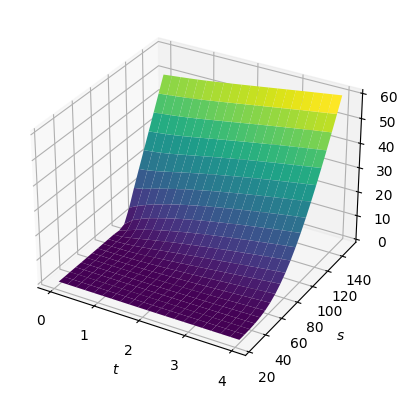

In [ ]:
result = DPDE_solution.detach().cpu().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(t_plot_mesh, s_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$t$')
ax.set_ylabel('$s$')
plt.show()



## Absolute error of model for differnet price and time

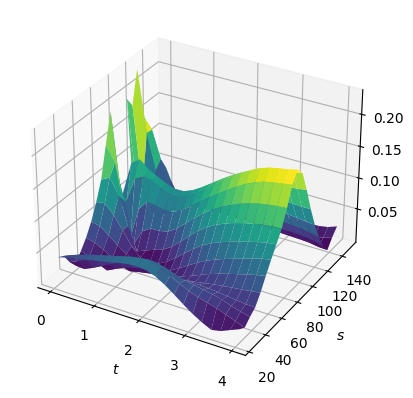

In [ ]:
result = np.abs(DPDE_solution.detach().cpu().numpy() - exact)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(t_plot_mesh, s_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$t$')
ax.set_ylabel('$s$')
plt.show()



## Showing the residual

In [ ]:
localisation =np.log(1+np.exp(localisation_parameter * (
          s_plot_mesh - strike_price * np.exp( -0.02 * t_plot_mesh)
            )))/localisation_parameter

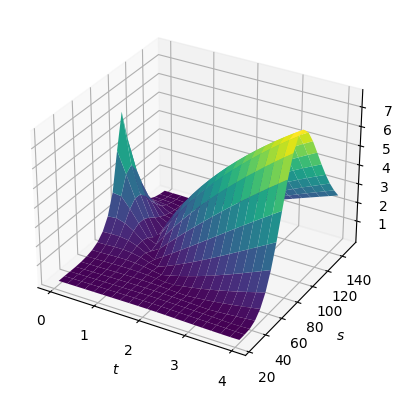

In [ ]:


result = np.abs(DPDE_solution.detach().cpu().numpy() - localisation)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(t_plot_mesh, s_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$t$')
ax.set_ylabel('$s$')
plt.show()



## Showing relative error of  implied volatility measure

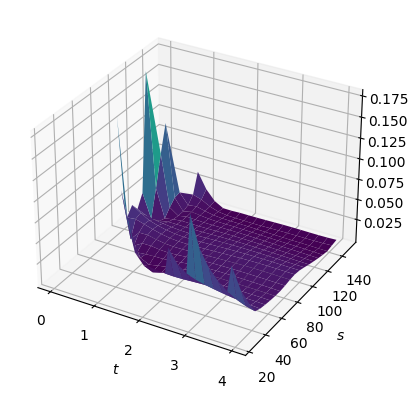

In [ ]:
result  = np.zeros((21,21))
approximate = DPDE_solution.detach().cpu().numpy()
for i in range(21):
  for j in range(21):

    lowerbound = lower_bound(t_plot_mesh[i,j],s_plot_mesh[i,j] , 100,0.02)
    if exact[i,j] - lowerbound > 0.05:
      est = np.sum(calculate_implied_volatility(s_plot_mesh[i,j],100,0.02,t_plot_mesh[i,j],approximate[i,j]))

      exactval = np.sum(calculate_implied_volatility(s_plot_mesh[i,j],100,0.02,t_plot_mesh[i,j],exact[i,j]))
      result[i,j] = np.abs(est - exactval)/exactval
    else :
      result[i,j] = None


fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(t_plot_mesh, s_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$t$')
ax.set_ylabel('$s$')
plt.show()



#Evaluating Model in Dimensio 2

In [ ]:
device = torch.device('cuda')

In [ ]:
dimension_state = 2
dimension_parameter = 4
dimension_total = 1 + dimension_state + dimension_parameter
solve = PDESolver(90,0.001,dimension_total)
solve.solve(5000,1000,device)

1
tensor(6.3588, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(5.4500, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(4.8404, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(4.2945, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(4.7825, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(4.5155, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(4.2199, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(4.4568, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(4.0135, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(3.5245, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(4.2997, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(3.8374, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(3.6141, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(3.6720, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(3.5888, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(3.6198, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(3.5370, device='cuda:0', grad_fn=<AddBackward0>)
18
ten

KeyboardInterrupt: ignored

In [ ]:
load_model = False
nr_samples_surface_plot = 21

In [ ]:
def localisation(t, s1, s2, riskfree_rate=riskfree_rate_eval):
    """ Return the value of the localisation used in the network. """
    return 1/localisation_parameter * np.log(1 +
                    np.exp(localisation_parameter * (
                        0.5*(s1+s2) - np.exp(-riskfree_rate*t)*strike_price))
                    )

In [ ]:
s1_plot_mesh, s2_plot_mesh, x_plot_normalised = get_points_for_plot_at_fixed_time()

covarince = torch.tensor([volatility1_eval,volatility2_eval]).reshape(1,2)
cor = torch.tensor([correlation_eval]).reshape(1,1)
cov = torch.squeeze(convert_to_covarince_matrix(covarince,cor))
w = torch.ones((2,1)) / 2.0

In [ ]:
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised).to(device).to(torch.float32)).reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

exact_solution_evaluated = [ExactSoloution(t=t_max , S0= np.concatenate((s1,s2)).reshape(2,1),CovMatrix=cov,w1=w , K= strike_price , riskfree_rate=riskfree_rate_eval)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))

                  ]
exact_solution_evaluated = np.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)



## Approximating of price for T = 4 , r= 0.02 and sigma = 0.2 , correlaion  = 0.5 in diffrent prices

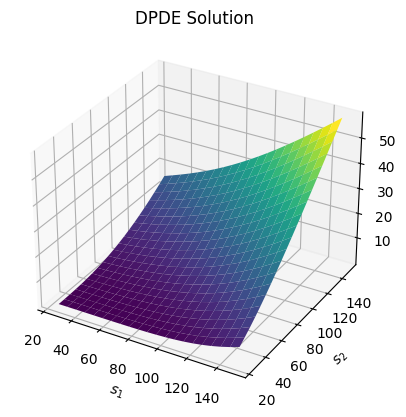

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, DPDE_solution.detach().cpu(), cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

## Error of model for T = 4 , r= 0.02 and sigma = 0.2 , correlaion  = 0.5 in diffrent prices

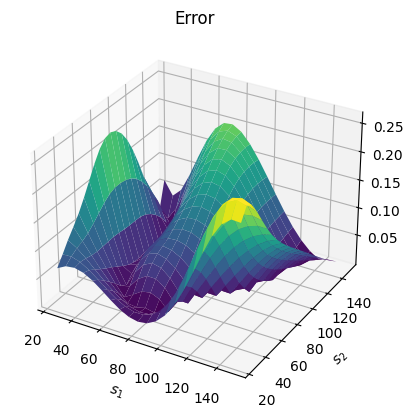

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(DPDE_solution.detach().cpu().numpy() - exact_solution_evaluated)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

## Residual for T = 4 , r= 0.02 and sigma = 0.2 , correlaion  = 0.5 in diffrent prices

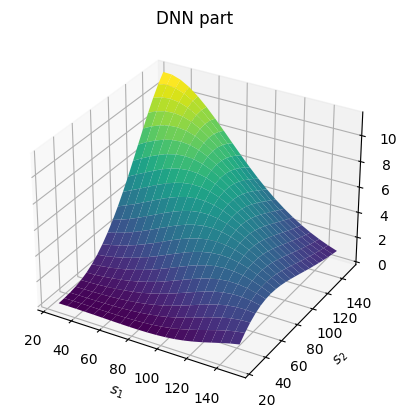

In [ ]:
localisation_plot = localisation(4., s1_plot_mesh, s2_plot_mesh, riskfree_rate_eval)


fig = plt.figure()
ax = plt.axes(projection='3d')

dnn_part = DPDE_solution.detach().cpu().numpy() - localisation_plot
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, dnn_part, cmap='viridis')
ax.set_title('DNN part')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

## Evaluating nodel in different parameter and price

In [ ]:
points , ww  = getPointsWeights(dimension_state - 1)
points = cp.array(points)
ww = cp.array(ww)

In [ ]:
samples_s,p,s_plot_mesh, p_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartying_parameter(dim = 2)
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(4410,dimension_total)).to(device).to(torch.float32)).reshape(
    21, 21,10)


w = torch.ones((dimension_state,1)) / dimension_state
s_sample = cp.array(samples_s)
w = cp.array(w)


covariance = torch.tensor(transform_to_volatility(p[: ,:,:,0 : dimension_state]))
corr = torch.tensor(transform_to_correlation(p[: ,:,:,dimension_state : 2*dimension_state -1]))
r = cp.array(transform_to_riskfree_rate(p[:, :,:,2*dimension_state -1 : 2*dimension_state ]))


exact_solution_evaluated = cp.zeros((21,21 ,10))
for i,(s,t) in enumerate(zip(s_plot_mesh, p_plot_mesh)):
  for j in range(len(s)):
    for k in range(10):
        cov = torch.squeeze(convert_to_covarince_matrix(covariance[i,j,k].reshape(1,dimension_state),corr[i,j,k].reshape(1,dimension_state - 1)))
        w = torch.ones((dimension_state,1)) / dimension_state
        V,D = decompose_covariance_matrix1(4,cov)
        V= cp.array(V)
        D = cp.array(D)
        cov = cp.array(cov)
        w = cp.array(w)
        exact_solution_evaluated[i,j,k] = ExactSoloutionEnhancedgpumore(4.0,s_sample[i,j,k,:].reshape(dimension_state,1),V,D,cov,100,w,r[i,j,k,0] , points , ww)


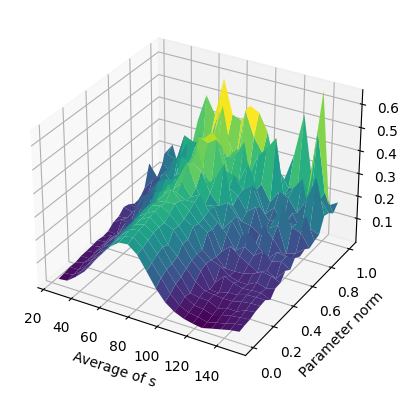

In [ ]:
result = np.max(np.abs(exact_solution_evaluated.get() - DPDE_solution.detach().cpu().numpy() ),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s_plot_mesh, p_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('Average of s ')
ax.set_ylabel(' Parameter norm')
plt.show()



# Fig 6a

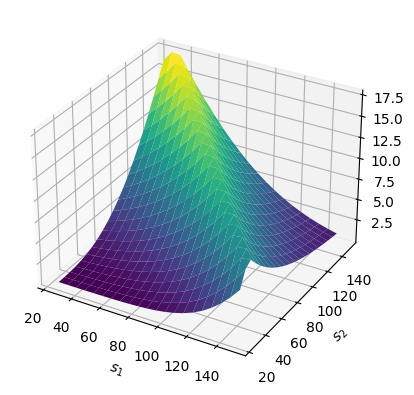

In [ ]:
result = exact_solution_evaluated  - lower_bound(4,(s1_plot_mesh+s2_plot_mesh)/2,100,0.02)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()



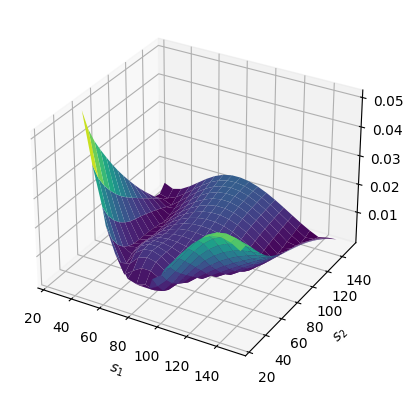

In [ ]:
result = np.zeros((np.shape(s1_plot_mesh)[0],np.shape(s1_plot_mesh)[1]))

for i in range(np.shape(s1_plot_mesh)[0]):
  for j in range(np.shape(s1_plot_mesh)[1]):
    if np.abs(exact_solution_evaluated[i,j]  - lower_bound(4,(s1_plot_mesh[i,j]+s2_plot_mesh[i,j])/2,100,0.02)) > 0.5 :
      est = calculate_implied_volatility((s1_plot_mesh[i,j]+s2_plot_mesh[i,j])/2 , 100,riskfree_rate_eval,4.0,DPDE_solution.detach().cpu().numpy()[i,j])
      exact = calculate_implied_volatility((s1_plot_mesh[i,j]+s2_plot_mesh[i,j])/2 , 100,riskfree_rate_eval,4.0,exact_solution_evaluated[i,j])
      result[i,j] = np.abs(est - exact)/(exact)

    else :
      result[i,j] = None
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()



#Relative error in implied volatility measure

In [ ]:
volatility1_eval = 0.3

s1_plot_mesh, s2_plot_mesh, x_plot_normalised = get_points_for_plot_at_fixed_time(volatility1_fixed= 0.3)

covarince = torch.tensor([volatility1_eval,volatility2_eval]).reshape(1,2)
cor = torch.tensor([correlation_eval]).reshape(1,1)
cov = torch.squeeze(convert_to_covarince_matrix(covarince,cor))
w = torch.ones((2,1)) / 2.0

DPDE_solution = solve.solver(torch.tensor(x_plot_normalised).to(device).to(torch.float32)).reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

exact_solution_evaluated = [ExactSoloution(t=t_max , S0= np.concatenate((s1,s2)).reshape(2,1),CovMatrix=cov,w1=w , K= strike_price , riskfree_rate=riskfree_rate_eval)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))

                  ]
exact_solution_evaluated = np.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

#localisation_plot = localisation(4., s1_plot_mesh, s2_plot_mesh, riskfree_rate_eval)


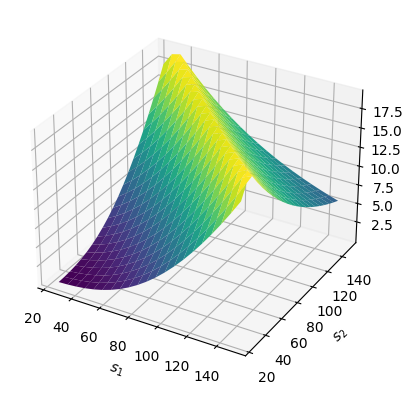

In [ ]:
result = exact_solution_evaluated  - lower_bound(4,(s1_plot_mesh+s2_plot_mesh)/2,100,0.02)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()



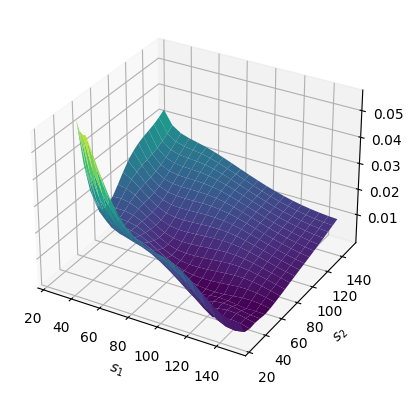

In [ ]:
result = np.zeros((np.shape(s1_plot_mesh)[0],np.shape(s1_plot_mesh)[1]))

for i in range(np.shape(s1_plot_mesh)[0]):
  for j in range(np.shape(s1_plot_mesh)[1]):
    if np.abs(exact_solution_evaluated[i,j]  - lower_bound(4,(s1_plot_mesh[i,j]+s2_plot_mesh[i,j])/2,100,0.02)) > 0.5 :
      exact = calculate_implied_volatility((s1_plot_mesh[i,j]+s2_plot_mesh[i,j])/2 , 100,riskfree_rate_eval,4.0,exact_solution_evaluated[i,j])

      est = calculate_implied_volatility((s1_plot_mesh[i,j]+s2_plot_mesh[i,j])/2 , 100,riskfree_rate_eval,4.0,DPDE_solution.detach().cpu().numpy()[i,j])
      result[i,j] = np.abs(est - exact)/(exact)

    else :
      result[i,j] = None
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()



#Evaluating model in Dimension 3

In [ ]:
dimension_state = 3
dimension_parameter = 6
dimension_total = 1 + dimension_state + dimension_parameter


solve = PDESolver(90,0.001,dimension_total)
solve.solve(5000,1000,device)

1
tensor(5.1035, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(4.9548, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(4.7138, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(3.7378, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(4.3326, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(3.6217, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(3.6657, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(3.7796, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(3.6698, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(4.0510, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(4.2481, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(4.0209, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(3.9949, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(3.5938, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(4.0288, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(3.8671, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(3.5154, device='cuda:0', grad_fn=<AddBackward0>)
18
ten

KeyboardInterrupt: ignored

## Error of model for different prices in fixed parameters

In [ ]:
s1_plot_mesh, s2_plot_mesh, s3_plot_mesh,x_plot_normalised = get_points_for_plot_at_fixed_time(volatility1_fixed=0.1,volatility2_fixed=0.2,volatility3_fixed=0.1,correlation_fixed1=0.2,correlation_fixed2=0.5)

covarince = torch.tensor([0.1,0.2,0.1]).reshape(1,3)
cor = torch.tensor([0.2,0.5]).reshape(1,2)
cov = torch.squeeze(convert_to_covarince_matrix(covarince,cor))
w = torch.ones((3,1)) / 3.0

In [ ]:
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised).to(device).to(torch.float32)).reshape(
    nr_samples_surface_plot, nr_samples_surface_plot,nr_samples_surface_plot)

In [ ]:
exact_solution_evaluated = [ExactSoloution(t=t_max , S0= np.concatenate((s1,s2,s3)).reshape(3,1),CovMatrix=cov,w1=w , K= strike_price , riskfree_rate=riskfree_rate_eval)
                  for s1, s2 , s3 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1) , s3_plot_mesh.reshape(-1, 1))

                  ]
exact_solution_evaluated = np.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot,nr_samples_surface_plot)

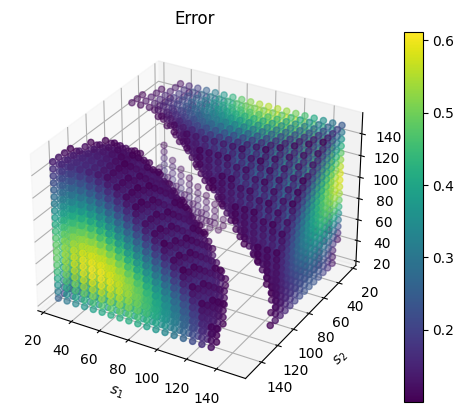

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(DPDE_solution.detach().cpu().numpy() - exact_solution_evaluated)
error[error < 0.1] =None

img = ax.scatter(s1_plot_mesh, s2_plot_mesh, s3_plot_mesh, c=error, cmap='viridis' )
fig.colorbar(img)

ax.set_title('Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
ax.set_zlabel('$s_3$')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])


plt.show()

## Relaive error of implied volatility measure in fixed parameters

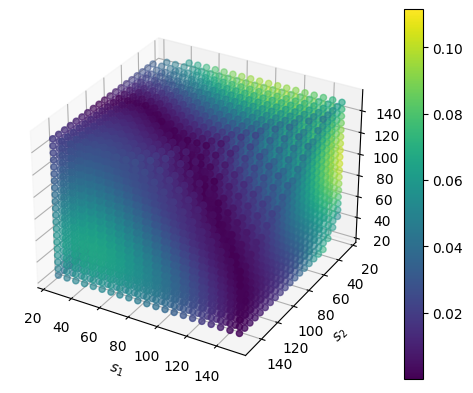

In [ ]:
result = np.zeros((np.shape(s1_plot_mesh)[0],np.shape(s1_plot_mesh)[1] ,np.shape(s1_plot_mesh)[2]))

for i in range(np.shape(s1_plot_mesh)[0]):
  for j in range(np.shape(s1_plot_mesh)[1]):
    for k in range(np.shape(s1_plot_mesh)[2]):
      if np.abs(exact_solution_evaluated[i,j,k]  - lower_bound(4,(s1_plot_mesh[i,j,k]+s2_plot_mesh[i,j,k] + s3_plot_mesh[i,j,k])/3,100,0.02)) > 0.5 :
        est = calculate_implied_volatility((s1_plot_mesh[i,j,k]+s2_plot_mesh[i,j,k] + s3_plot_mesh[i,j,k])/3 , 100,riskfree_rate_eval,4.0,DPDE_solution.detach().cpu().numpy()[i,j,k])
        exact = calculate_implied_volatility((s1_plot_mesh[i,j,k]+s2_plot_mesh[i,j,k] + s3_plot_mesh[i,j,k])/3 , 100,riskfree_rate_eval,4.0,exact_solution_evaluated[i,j,k])
        result[i,j,k] = np.abs(est - exact)/(exact)

      else :
        result[i,j,k] = None
fig = plt.figure()
ax = plt.axes(projection='3d')

img = ax.scatter(s1_plot_mesh, s2_plot_mesh, s3_plot_mesh, c=result, cmap='viridis' )
fig.colorbar(img)
ax.set_title('')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
ax.set_zlabel('$s_3$')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

plt.show()


## Evaluting model in different parameters and prices in Dimension 3

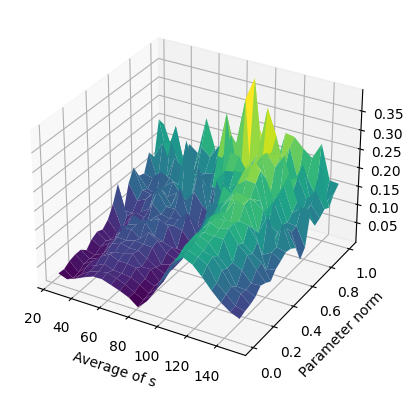

In [ ]:
points , ww  = getPointsWeights(dimension_state - 1)
points = cp.array(points)
ww = cp.array(ww)


samples_s,p,s_plot_mesh, p_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartying_parameter(dim = dimension_state)
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(4410,dimension_total)).to(device).to(torch.float32)).reshape(
    21, 21,10)


w = torch.ones((dimension_state,1)) / dimension_state
s_sample = cp.array(samples_s)
w = cp.array(w)


covariance = torch.tensor(transform_to_volatility(p[: ,:,:,0 : dimension_state]))
corr = torch.tensor(transform_to_correlation(p[: ,:,:,dimension_state : 2*dimension_state -1]))
r = cp.array(transform_to_riskfree_rate(p[:, :,:,2*dimension_state -1 : 2*dimension_state ]))


exact_solution_evaluated = cp.zeros((21,21 ,10))
for i,(s,t) in enumerate(zip(s_plot_mesh, p_plot_mesh)):
  for j in range(len(s)):
    for k in range(10):
        cov = torch.squeeze(convert_to_covarince_matrix(covariance[i,j,k].reshape(1,dimension_state),corr[i,j,k].reshape(1,dimension_state - 1)))
        w = torch.ones((dimension_state,1)) / dimension_state
        V,D = decompose_covariance_matrix1(4,cov)
        V= cp.array(V)
        D = cp.array(D)
        cov = cp.array(cov)
        w = cp.array(w)
        exact_solution_evaluated[i,j,k] = ExactSoloutionEnhancedgpumore(4.0,s_sample[i,j,k,:].reshape(dimension_state,1),V,D,cov,100,w,r[i,j,k,0] , points , ww)


result = np.max(np.abs(exact_solution_evaluated.get() - DPDE_solution.detach().cpu().numpy() ),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s_plot_mesh, p_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('Average of s ')
ax.set_ylabel(' Parameter norm')
plt.show()



# Evaluating modle in  Dimension 5

In [ ]:
dimension_state = 5
dimension_parameter = 10
dimension_total = 1 + dimension_state + dimension_parameter


device = torch.device('cuda')
solve = PDESolver(90,0.0008,dimension_total)
solve.solve(5000,1000,device)

1
tensor(4.8825, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(4.7187, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(3.8962, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(4.7117, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(4.0957, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(3.8951, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(3.4977, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(3.8445, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(3.4425, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(3.6784, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(3.5578, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(3.3601, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(3.3650, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(3.3169, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(3.4999, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(3.0237, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(3.1488, device='cuda:0', grad_fn=<AddBackward0>)
18
ten

KeyboardInterrupt: ignored

In [ ]:
s_sample, s_plot_mesh, t_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartying_time_mored()
covarince = torch.ones((1,5))* 0.2
cor = torch.ones((1,4)) * 0.5
cov = torch.squeeze(convert_to_covarince_matrix(covarince,cor))
w = torch.ones((5,1)) / 5.0

V,D = decompose_covariance_matrix1(1,cov)

DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(4410,16)).to(device).to(torch.float32)).reshape(
    21, 21,10)

In [ ]:
points , ww  = getPointsWeights(dimension_state - 1)

##  Model approximation  for different time and mean  price

In [ ]:
s_sample = cp.array(s_sample)
V= cp.array(V)
D = cp.array(D)
cov = cp.array(cov)
w = cp.array(w)

In [ ]:
exact_solution_evaluated = cp.zeros((21,21 ,10))
for i,(s,t) in enumerate(zip(s_plot_mesh, t_plot_mesh)):
  for j in range(len(s)):
    for k in range(10):
      exact_solution_evaluated[i,j,k] = ExactSoloutionEnhancedgpumore(t[j],s_sample[i,j,k,:].reshape(dimension_state,1),V,t[j]*D,cov,100,w,0.02 , points , ww)

exact_solution_evaluated = cp.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    21, 21 , 10)

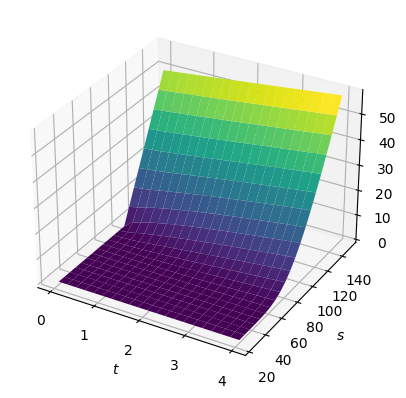

In [ ]:
result = np.mean(exact_solution_evaluated.get(),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(t_plot_mesh, s_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$t$')
ax.set_ylabel('$s$')
plt.show()



## Maximal error for differnt time and average price

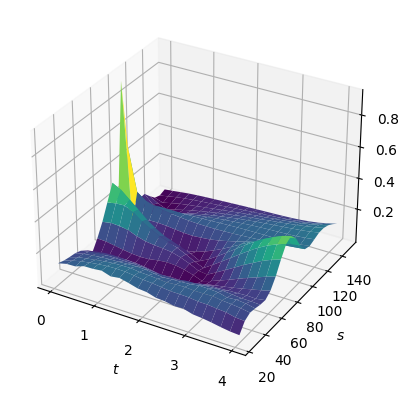

In [ ]:
result = np.max(np.abs(exact_solution_evaluated.get() - DPDE_solution.detach().cpu().numpy() ),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(t_plot_mesh, s_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$t$')
ax.set_ylabel('$s$')
plt.show()



## Statistical property of model error

In [ ]:
x = np.random.uniform(-1,1,size=[1000,dimension_total])
approximate = solve.solver(torch.tensor(x).to(torch.float32).to(device)).detach().cpu().numpy()
exact_value = np.zeros((1000,))


rel_implied = np.zeros((1000,))


time = transform_to_time(x[:,0])
stock_price  = cp.array(np.exp(transform_to_logprice(x[:, 1: dimension_state + 1])))
covariance = torch.tensor(transform_to_volatility(x[: ,dimension_state + 1 : 2*dimension_state + 1 ]))
corr = torch.tensor(transform_to_correlation(x[: ,2*dimension_state + 1 : 3*dimension_state]))
r = cp.array(transform_to_riskfree_rate(x[:, 3*dimension_state : 3*dimension_state + 1]))

for i in range(1000) :

  cov = torch.squeeze(convert_to_covarince_matrix(covariance[i].reshape(1,dimension_state),corr[i].reshape(1,dimension_state - 1)))
  w = torch.ones((5,1)) / 5.0
  V,D = decompose_covariance_matrix1(1,cov)
  V= cp.array(V)
  D = cp.array(D)
  cov = cp.array(cov)
  w = cp.array(w)
  exact_value[i] = ExactSoloutionEnhancedgpumore(time[i],stock_price[i].reshape(dimension_state,1),V,time[i]*D,cov,100,w,r[i] , points , ww)
  lowerbound  = lower_bound(time[i],cp.mean(stock_price[i]) , 100,r[i])
  if exact_value[i] - lowerbound > 0.5 :
    est = calculate_implied_volatility(cp.mean(stock_price[i]).get(),100,r[i].get(),time[i],approximate[i,0])
    exact = calculate_implied_volatility(cp.mean(stock_price[i]).get(),100,r[i].get(),time[i],exact_value[i])
    rel_implied[i] = (est - exact)/exact
  else :
    rel_implied[i] = None






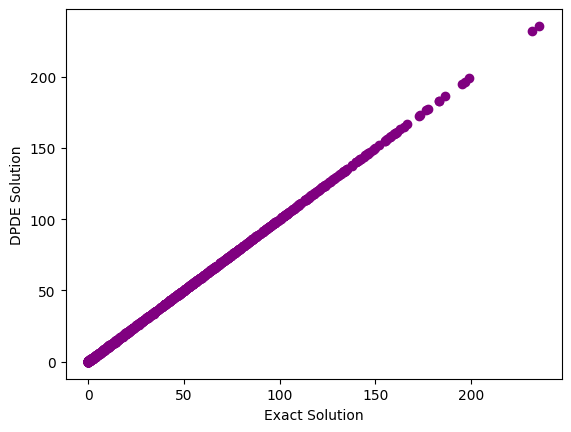

In [ ]:
plt.scatter(exact_value, approximate , c = 'purple')
plt.xlabel('Exact Solution')
plt.ylabel('DPDE Solution')
plt.show()

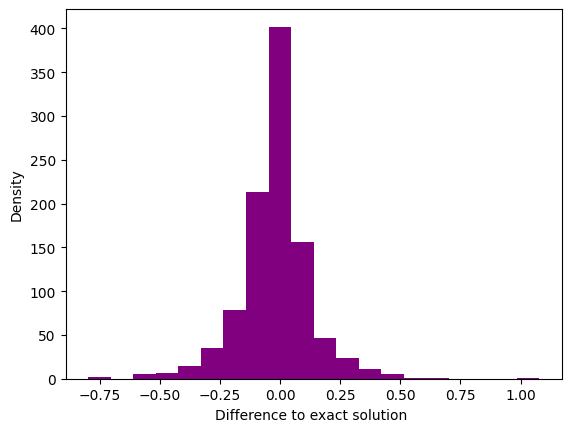

In [ ]:
plt.hist(-1*exact_value + approximate[:,0],color = 'purple' , bins=20);
plt.xlabel('Difference to exact solution ')
plt.ylabel('Density')
plt.show()

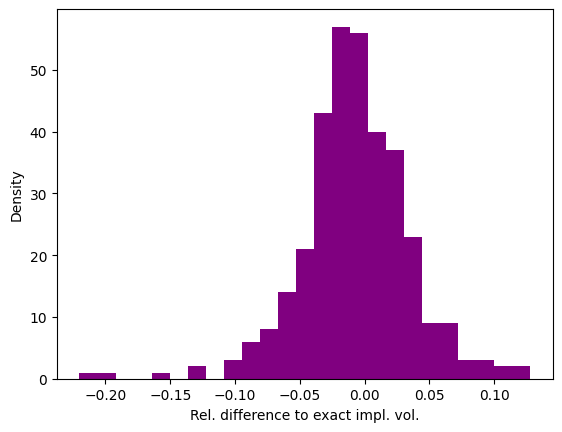

In [ ]:
plt.hist(rel_implied[rel_implied < 0.5],color = 'purple' , bins=25);
plt.xlabel('Rel. difference to exact impl. vol.')
plt.ylabel('Density')
plt.show()

## Model error for different parameter and price

In [ ]:
samples_s,p,s_plot_mesh, p_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartying_parameter()
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(4410,16)).to(device).to(torch.float32)).reshape(
    21, 21,10)


w = torch.ones((5,1)) / 5.0
s_sample = cp.array(s_sample)
w = cp.array(w)


covariance = torch.tensor(transform_to_volatility(p[: ,:,:,0 : dimension_state]))
corr = torch.tensor(transform_to_correlation(p[: ,:,:,dimension_state : 2*dimension_state -1]))
r = cp.array(transform_to_riskfree_rate(p[:, :,:,2*dimension_state -1 : 2*dimension_state ]))


exact_solution_evaluated = cp.zeros((21,21 ,10))
for i,(s,t) in enumerate(zip(s_plot_mesh, p_plot_mesh)):
  for j in range(len(s)):
    for k in range(10):
        cov = torch.squeeze(convert_to_covarince_matrix(covariance[i,j,k].reshape(1,dimension_state),corr[i,j,k].reshape(1,dimension_state - 1)))
        w = torch.ones((5,1)) / 5.0
        V,D = decompose_covariance_matrix1(4,cov)
        V= cp.array(V)
        D = cp.array(D)
        cov = cp.array(cov)
        w = cp.array(w)
        exact_solution_evaluated[i,j,k] = ExactSoloutionEnhancedgpumore(4.0,s_sample[i,j,k,:].reshape(dimension_state,1),V,D,cov,100,w,r[i,j,k,0] , points , ww)


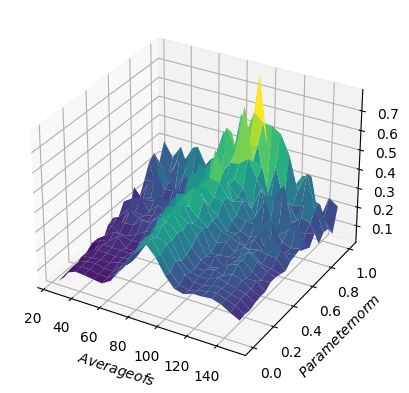

In [ ]:
result = np.max(np.abs(exact_solution_evaluated.get() - DPDE_solution.detach().cpu().numpy() ),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s_plot_mesh, p_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$Average of s$')
ax.set_ylabel('$Parameter norm$')
plt.show()



# Evaluting model in Dimension 8

In [ ]:
dimension_state = 8
dimension_parameter = 16
dimension_total = 1 + dimension_state + dimension_parameter


device = torch.device('cuda')
solve = PDESolver(90,0.001,dimension_total)
solve.solve(5000,1000,device)

1
tensor(4.9145, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(4.0573, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(4.2204, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(3.7680, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(3.5957, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(3.5269, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(3.5075, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(3.4394, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(2.7323, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(2.9048, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(3.0969, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(3.0458, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(2.4766, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(2.7999, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(2.6592, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(2.5044, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(2.7153, device='cuda:0', grad_fn=<AddBackward0>)
18
ten

KeyboardInterrupt: ignored

In [ ]:
s_sample, s_plot_mesh, t_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartying_time_mored(dim=dimension_state)
covarince = torch.ones((1,8))* 0.2
cor = torch.ones((1,7)) * 0.5
cov = torch.squeeze(convert_to_covarince_matrix(covarince,cor))
w = torch.ones((8,1)) / 8.0

V,D = decompose_covariance_matrix1(1,cov)



In [ ]:
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(4410,25)).to(device).to(torch.float32)).reshape(
    21, 21,10)

In [ ]:
points , ww  = getPointsWeights(dimension_state - 1)

In [ ]:
s_sample = cp.array(s_sample)
V= cp.array(V)
D = cp.array(D)
cov = cp.array(cov)
w = cp.array(w)

points = cp.array(points)
ww = cp.array(ww)

In [ ]:
exact_solution_evaluated = cp.zeros((21,21 ,10))
for i,(s,t) in enumerate(zip(s_plot_mesh, t_plot_mesh)):
  for j in range(len(s)):
    for k in range(10):
      exact_solution_evaluated[i,j,k] = ExactSoloutionEnhancedgpumore(t[j],s_sample[i,j,k,:].reshape(dimension_state,1),V,t[j]*D,cov,100,w,0.02 , points , ww)

exact_solution_evaluated = cp.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    21, 21 , 10)

## Approximated price

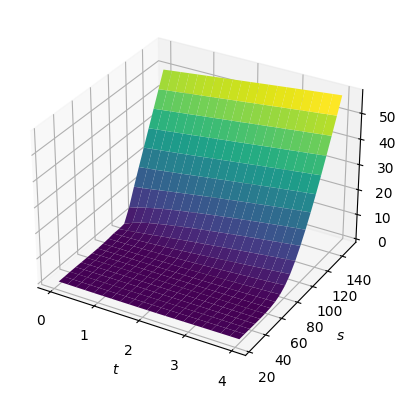

In [ ]:
result = np.mean(DPDE_solution.detach().cpu().numpy(),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(t_plot_mesh, s_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$t$')
ax.set_ylabel('$s$')
plt.show()



## Maximal error of model for differnt time and mean price

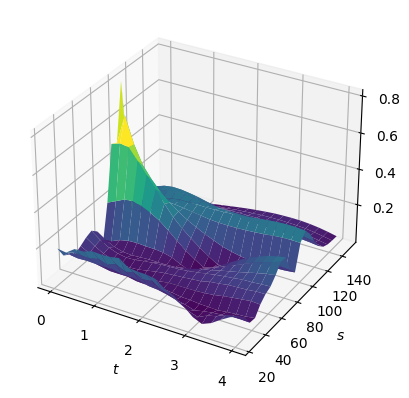

In [ ]:
result = np.max(np.abs(exact_solution_evaluated.get() - DPDE_solution.detach().cpu().numpy() ),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(t_plot_mesh, s_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('$t$')
ax.set_ylabel('$s$')
plt.show()



## Statistical property of model error

In [ ]:
x = np.random.uniform(-1,1,size=[1000,dimension_total])
approximate = solve.solver(torch.tensor(x).to(torch.float32).to(device)).detach().cpu().numpy()
exact_value = np.zeros((1000,))


rel_implied = np.zeros((1000,))


time = transform_to_time(x[:,0])
stock_price  = cp.array(np.exp(transform_to_logprice(x[:, 1: dimension_state + 1])))
covariance = torch.tensor(transform_to_volatility(x[: ,dimension_state + 1 : 2*dimension_state + 1 ]))
corr = torch.tensor(transform_to_correlation(x[: ,2*dimension_state + 1 : 3*dimension_state]))
r = cp.array(transform_to_riskfree_rate(x[:, 3*dimension_state : 3*dimension_state + 1]))

for i in range(1000) :

  cov = torch.squeeze(convert_to_covarince_matrix(covariance[i].reshape(1,dimension_state),corr[i].reshape(1,dimension_state - 1)))
  w = torch.ones((8,1)) / 8.0
  V,D = decompose_covariance_matrix1(1,cov)
  V= cp.array(V)
  D = cp.array(D)
  cov = cp.array(cov)
  w = cp.array(w)
  exact_value[i] = ExactSoloutionEnhancedgpumore(time[i],stock_price[i].reshape(dimension_state,1),V,time[i]*D,cov,100,w,r[i] , points , ww)
  lowerbound  = lower_bound(time[i],cp.mean(stock_price[i]) , 100,r[i])
  if exact_value[i] - lowerbound > 0.5 :
    est = calculate_implied_volatility(cp.mean(stock_price[i]).get(),100,r[i].get(),time[i],approximate[i,0])
    exact = calculate_implied_volatility(cp.mean(stock_price[i]).get(),100,r[i].get(),time[i],exact_value[i])
    rel_implied[i] = (est - exact)/exact
  else :
    rel_implied[i] = None






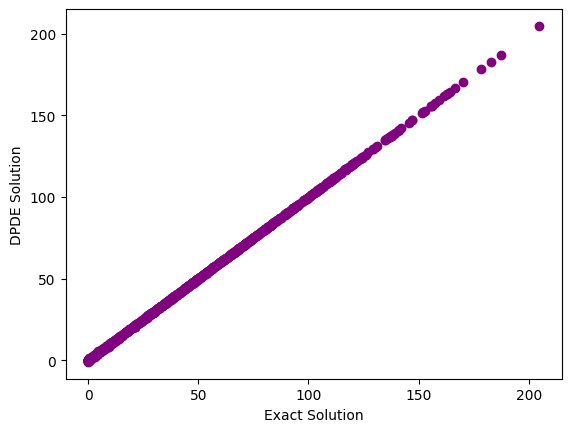

In [ ]:
plt.scatter(exact_value, approximate , c = 'purple')
plt.xlabel('Exact Solution')
plt.ylabel('DPDE Solution')
plt.show()

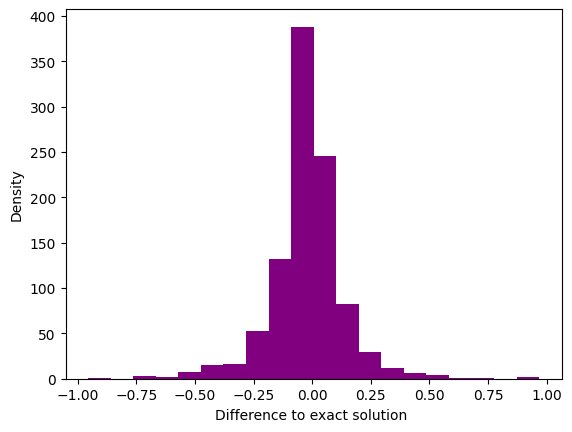

In [ ]:
plt.hist(-1*exact_value + approximate[:,0],color = 'purple' , bins=20);
plt.xlabel('Difference to exact solution ')
plt.ylabel('Density')
plt.show()

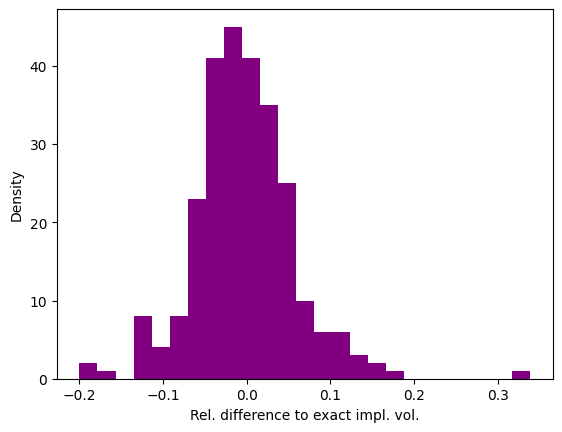

In [ ]:
plt.hist(rel_implied[rel_implied < 0.5],color = 'purple' , bins=25);
plt.xlabel('Rel. difference to exact impl. vol.')
plt.ylabel('Density')
plt.show()

## Error of model for differnt parameters and mean price

In [ ]:
points , ww  = getPointsWeights(dimension_state - 1,sampleInEachAxis=8 )
points = cp.array(points)
ww = cp.array(ww)



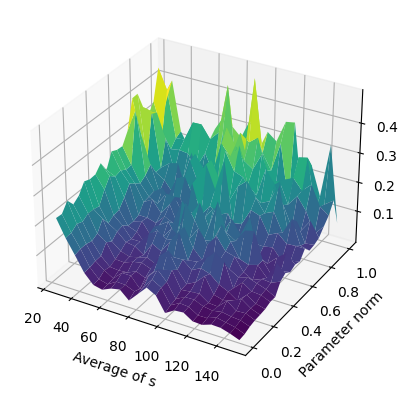

In [ ]:

samples_s,p,s_plot_mesh, p_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartying_parameter(dim = dimension_state)
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(4410,dimension_total)).to(device).to(torch.float32)).reshape(
    21, 21,10)


w = torch.ones((dimension_state,1)) / dimension_state
s_sample = cp.array(samples_s)
w = cp.array(w)


covariance = torch.tensor(transform_to_volatility(p[: ,:,:,0 : dimension_state]))
corr = torch.tensor(transform_to_correlation(p[: ,:,:,dimension_state : 2*dimension_state -1]))
r = cp.array(transform_to_riskfree_rate(p[:, :,:,2*dimension_state -1 : 2*dimension_state ]))


exact_solution_evaluated = cp.zeros((21,21 ,10))
for i,(s,t) in enumerate(zip(s_plot_mesh, p_plot_mesh)):
  for j in range(len(s)):
    for k in range(10):
        cov = torch.squeeze(convert_to_covarince_matrix(covariance[i,j,k].reshape(1,dimension_state),corr[i,j,k].reshape(1,dimension_state - 1)))
        w = torch.ones((dimension_state,1)) / dimension_state
        V,D = decompose_covariance_matrix1(4,cov)
        V= cp.array(V)
        D = cp.array(D)
        cov = cp.array(cov)
        w = cp.array(w)
        exact_solution_evaluated[i,j,k] = ExactSoloutionEnhancedgpumore(4.0,s_sample[i,j,k,:].reshape(dimension_state,1),V,D,cov,100,w,r[i,j,k,0] , points , ww)


result = np.max(np.abs(exact_solution_evaluated.get() - DPDE_solution.detach().cpu().numpy() ),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s_plot_mesh, p_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('Average of s ')
ax.set_ylabel(' Parameter norm')
plt.show()



# Evaluting model for Geometric payoff

we need to change some function in this part

In [ ]:
def geometric_option_pricing(t,x,r,k,var , cor,dim):
  var_bar = var/dim *(1+(dim-1)*cor)
  q = (var - var_bar)/2
  x_bar = np.mean(x,1 , keepdims=True)
  d1 = (x_bar - np.log(k) + r*t - q*t + var_bar/2 *t)/(np.sqrt(t*var_bar))
  d2 = d1 - np.sqrt(var_bar * t)
  option_price = norm.cdf(d1) * np.exp(-1 * q * t + x_bar) - norm.cdf(d2)*k*np.exp(-r * t)
  return option_price

In [ ]:
class NuarlBox(nn.Module):
  def __init__(self,
              indim=100,
              outdim = 50
              ):
    super().__init__()
    self.acitivision = nn.Tanh()
    self.z = nn.Linear(outdim,outdim,bias=False)
    self.g = nn.Linear(outdim,outdim,bias=False)
    self.r = nn.Linear(outdim,outdim,bias=False)
    self.h = nn.Linear(outdim,outdim,bias=False)
    self.z1 = nn.Linear(outdim,outdim)
    self.g1 = nn.Linear(outdim,outdim)
    self.r1 = nn.Linear(outdim,outdim)
    self.h1 = nn.Linear(outdim,outdim)
    self.s1 = nn.Linear(indim,outdim)
    self.s2 = nn.Linear(indim ,outdim)
    self.s3 = nn.Linear(indim ,outdim)
    self.s4 = nn.Linear(indim ,outdim)







  def forward(self, x,s):

    z1 =self.z(s) + self.s1(x)
    z1 = self.acitivision(z1)
    g1 = self.g(s) + self.s2(x)
    g1 = self.acitivision(g1)
    r1 = self.r(s) + self.s3(x)
    r1 = self.acitivision(r1)
    h1 = self.h(torch.mul(s,r1)) + self.s4(x)
    h1 = self.acitivision(h1)
    s2 = torch.mul((1.0-g1),h1) + torch.mul(z1,s)
    return s2


class DeepParametricGeometric(nn.Module):
  def __init__(self,

              dim=100,
              layersize = 50,
              ):
    super().__init__()


    self.dim = dim
    self.layer1 = nn.Linear(self.dim  , layersize)
    self.module1 = NuarlBox(indim = self.dim ,outdim = layersize)
    self.module2 = NuarlBox(indim = self.dim ,outdim = layersize)
    self.module3 = NuarlBox(indim = self.dim,outdim = layersize)
    self.module4 = NuarlBox(indim = self.dim,outdim = layersize)
    self.last_layer = nn.Linear(layersize,1)

    self.acitivision  = nn.Tanh()


  def forward(self,y):

    s1=self.layer1(y)
    s1= self.acitivision(s1)
    s2 = self.module1(y,s1)
    s3 = self.module2(y,s2)
    s4 = self.module3(y,s3)
    out =self.last_layer(s4)
    iterior = y
    volatility = transform_to_volatility(iterior[:, dimension_state + 1:dimension_state + 2])
    correlation = transform_to_correlation(iterior[:, dimension_state + 2:dimension_state + 3])
    riskfree =  transform_to_riskfree_rate(iterior[:, dimension_state + 3 :dimension_state + 4])
    inputs_t = transform_to_time(iterior[:,0:1])

    inputs_x_mean = torch.sum((transform_to_logprice(iterior[:,1:dimension_state + 1])) , dim = 1).reshape(y.size()[0] , 1) / dimension_state
    beta = volatility**2 /2*(1-1.0/dimension_state)*(1-correlation)
    localisation =torch.log(1+torch.exp(localisation_parameter * (
          torch.exp(inputs_x_mean)*torch.exp(-beta * inputs_t) - strike_price * torch.exp( -riskfree * inputs_t)
            )))/localisation_parameter
    return out + localisation

In [ ]:
def convert_to_covarince_matrix_geometric(dim , vol , corr,device):
  n = vol.size()[0]
  correlation = torch.abs(torch.diag_embed( torch.ones((n,dim)).to(device) * (1+corr.reshape(n,1))) - torch.ones((n,dim , dim)).to(device) * corr.reshape(n,1,1))

  covariance = correlation * (vol.reshape(n,1,1) ** 2)
  return covariance




In [ ]:

def initialize_weights(m: nn.Module) -> None:
  """
  Initializes the weights of the given module.

  Args:
  - m (nn.Module): the module to initialize weights of

  Returns:
  - None
  """
  if isinstance(m, nn.Linear):
    torch.nn.init.normal_(m.weight, 0,0.05)
    #torch.nn.init.normal_(m.bias, 0,0.05)

class PDESolvergeometric:
  def __init__(self, layersizes,lr,totaldim):
    self.layersize = layersizes
    self.lr = lr
    self.totaldim = totaldim

    self.solver  = DeepParametricGeometric(dim = self.totaldim, layersize=self.layersize)
    #self.solver.apply(initialize_weights)


    self.optimizer = torch.optim.Adam(self.solver.parameters(), lr=self.lr)
  def solve(self, nIteration ,batch_size,device):
    losses = []
    inits = []
    self.solver.to(device)


    torch.seed()
    self.solver.train()


    for j in range(nIteration):
      print(j+1)


      self.optimizer.zero_grad()

      iterior , initial = DPDEGenerator(batch_size).__getitem__()
      iterior = torch.tensor(iterior).to(device).to(torch.float32)
      iterior = iterior.requires_grad_(True)


      out = self.solver(iterior)
      first_derivative = autograd.grad(out.sum(), iterior, create_graph=True)[0]
      dt = first_derivative[:,0:1]*diff_dt
      dx = first_derivative[:,1:dimension_state + 1] * diff_dx
      dxdx = batch_jacobian(self.solver,iterior)[:,1:dimension_state + 1,1:dimension_state + 1] * diff_dx * diff_dx

      # dxdx = autograd.grad(torch.sum(dx,dim = 1), iterior[:,1:dimension_state + 1], create_graph=True)[0]* diff_dx
      volatility = transform_to_volatility(
              iterior[:, dimension_state + 1:dimension_state + 2])

      correlation = transform_to_correlation(iterior[:, dimension_state + 2:dimension_state + 3])
      riskfree =  transform_to_riskfree_rate(iterior[:, dimension_state + 3:dimension_state + 4])
      inputs_t = transform_to_time(iterior[:,0:1])
      cov  = convert_to_covarince_matrix_geometric(dimension_state,volatility,correlation,device)

      interior_loss = -1 *torch.squeeze(dt) + torch.squeeze(torch.sum((riskfree - volatility.to(torch.float32)**2 /2) * dx,dim = 1))  + 0.5 * torch.squeeze((cov*dxdx).sum(-1).sum(-1)) - torch.squeeze(riskfree * out)




      initial = torch.tensor(initial).to(device).to(torch.float32)





      xinitial = transform_to_logprice(initial[:,1:dimension_state + 1])
      s_mean_initial = (xinitial).sum(dim = 1) /dimension_state

      payoff = nn.ReLU()(torch.exp(s_mean_initial) -strike_price )

      out1 = self.solver(initial)


      loss = torch.mean(interior_loss**2)+ torch.mean((torch.squeeze(payoff) - torch.squeeze(out1))**2)
      print( loss)


      loss.backward()

      self.optimizer.step()

    return losses,inits


In [ ]:
def get_points_for_plot_at_vartying_parameter (t = t_max,
                                               dim = 5,
                                               insample = 10,
                                               s_min_interest=s_min_interest,
                                               s_max_interest=s_max_interest,
                                               n_plot=21):
    """ Get the spacial and normalised values for surface plots
    at fixed time and parameter, varying both asset prices.
    """
    s_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    p_plot = np.linspace(0, normalised_max, n_plot).reshape(-1,1)


    [s_plot_mesh, p_plot_mesh] = np.meshgrid(s_plot, p_plot,indexing='ij')

    samples_s =genrate_random_asset_with_same_average(s_plot_mesh , dim , insample)
    x = normalise_logprice(np.log(samples_s ))
    p = genrate_random_asset_with_same_norm( p_plot_mesh , 3 , insample )




    t_mesh = np.ones((n_plot,n_plot,insample,1)) *  t_max
    t_mesh_normalised = normalise_time(t_mesh)



    x_plot_normalised = np.concatenate((t_mesh_normalised,
                                        x,
                                        p), axis=3)


    return samples_s,p,s_plot_mesh, p_plot_mesh, x_plot_normalised


## Approximating of model in Dim 2 for Geometric payoff

In [ ]:
dimension_state = 2
dimension_parameter = 3
dimension_total = 1 + dimension_state + dimension_parameter


device = torch.device('cuda')
solve = PDESolvergeometric(90,0.001,dimension_total)
solve.solve(5000,1000,device)

1
tensor(7.9015, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(6.6956, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(6.5504, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(6.2277, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(5.8473, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(4.9479, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(5.0368, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(4.7609, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(5.0700, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(5.0905, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(4.7761, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(5.1186, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(4.1172, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(4.7869, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(4.2893, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(4.1842, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(4.1508, device='cuda:0', grad_fn=<AddBackward0>)
18
ten

KeyboardInterrupt: ignored

In [ ]:
def get_points_for_plot_at_fixed_time(t_fixed=t_max,
                s_min_interest=s_min_interest, s_max_interest=s_max_interest,
                riskfree_rate_fixed=riskfree_rate_eval,
                volatility_fixed=0.1,
                correlation_fixed = 0.5,
                n_plot=21):
    """ Get the spacial and normalised values for surface plots
    at fixed time and parameter, varying both asset prices.
    """
    s1_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    s2_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    [s1_plot_mesh, s2_plot_mesh] = np.meshgrid(s1_plot, s2_plot, indexing='ij')

    x1_plot_mesh_normalised = normalise_logprice(
        np.log(s1_plot_mesh)).reshape(-1,1)

    x2_plot_mesh_normalised = normalise_logprice(
        np.log(s2_plot_mesh)).reshape(-1,1)

    t_mesh = t_fixed  * np.ones((n_plot**2, 1))
    t_mesh_normalised = normalise_time(t_mesh)

    parameter1_mesh_normalised = (normalise_riskfree_rate(riskfree_rate_fixed)
                                                      * np.ones((n_plot**2, 1)))
    parameter2_mesh_normalised = (normalise_volatility(volatility_fixed)
                                                      * np.ones((n_plot**2, 1)))

    parameter3_mesh_normalised = (normalise_correlation(correlation_fixed)
                                                      * np.ones((n_plot**2, 1)))

    x_plot_normalised = np.concatenate((t_mesh_normalised,
                                        x1_plot_mesh_normalised,
                                        x2_plot_mesh_normalised,
                                        parameter2_mesh_normalised,
                                        parameter3_mesh_normalised,
                                        parameter1_mesh_normalised), axis=1)


    return s1_plot_mesh, s2_plot_mesh, x_plot_normalised

### Appoximate price

In [ ]:
s1_plot_mesh, s2_plot_mesh, x_plot_normalised = get_points_for_plot_at_fixed_time()
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised).to(device).to(torch.float32)).reshape(
    21, 21)



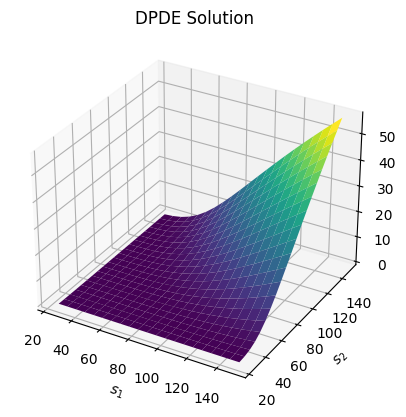

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, DPDE_solution.detach().cpu(), cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

In [ ]:
volatility = transform_to_volatility(x_plot_normalised[:, dimension_state + 1:dimension_state + 2])
correlation = transform_to_correlation(x_plot_normalised[:, dimension_state + 2:dimension_state + 3])
riskfree =  transform_to_riskfree_rate(x_plot_normalised[:, dimension_state + 3 :dimension_state + 4])
inputs_t = transform_to_time(x_plot_normalised[:,0:1])
x = transform_to_logprice(x_plot_normalised[:,1:dimension_state+1])

inputs_x_mean = np.mean(x ,  1 , keepdims= True)
beta = volatility**2 /2*(1-1.0/dimension_state)*(1-correlation)
localisation =np.log(1+np.exp(localisation_parameter * (
      np.exp(inputs_x_mean)*np.exp(-beta * inputs_t) - strike_price * np.exp( -riskfree * inputs_t)
        )))/localisation_parameter
localisation = localisation.reshape(
    21, 21)

exact_solution_evaluated = geometric_option_pricing(inputs_t , x, riskfree , 100,volatility**2 , correlation,dimension_state)


exact_solution_evaluated = np.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    21, 21)

### error of price

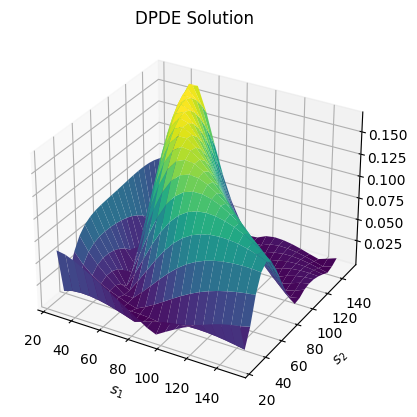

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh,np.abs( DPDE_solution.detach().cpu()-exact_solution_evaluated), cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

### residual of price

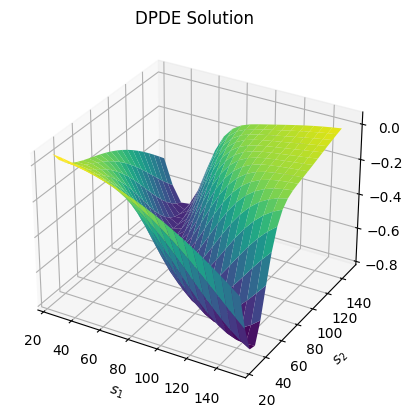

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh,( DPDE_solution.detach().cpu()-localisation), cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

## Evaluting model for differnt parameters and mean price in different dimension

### Dim 3

In [ ]:
dimension_state = 3
dimension_parameter = 3
dimension_total = 1 + dimension_state + dimension_parameter


device = torch.device('cuda')
solve = PDESolvergeometric(90,0.001,dimension_total)
solve.solve(5000,1000,device)

1
tensor(6.1846, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(6.6356, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(6.1294, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(6.1563, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(5.3828, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(5.0742, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(4.9821, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(5.1578, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(5.2395, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(4.8664, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(4.8335, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(4.5341, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(4.6674, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(4.5705, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(4.3475, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(3.9506, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(4.1839, device='cuda:0', grad_fn=<AddBackward0>)
18
ten

KeyboardInterrupt: ignored

In [ ]:
samples_s,p,s_plot_mesh, p_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartying_parameter(dim = 3)
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(4410,dimension_total)).to(device).to(torch.float32)).reshape(
    21, 21,10)


w = np.array((dimension_state,1)) / dimension_state



samples_s =samples_s
covariance = transform_to_volatility(p[: ,:,:,0 : 1])
corr = transform_to_correlation(p[: ,:,:,1 : 2])
r =  transform_to_riskfree_rate(p[:, :,:,2 : 3 ])


exact_solution_evaluated = np.zeros((21,21 ,10))
for i,(s,t) in enumerate(zip(s_plot_mesh, p_plot_mesh)):
  for j in range(len(s)):
    for k in range(10):

        exact_solution_evaluated[i,j,k] = geometric_option_pricing(4,np.log(samples_s[i,j,k].reshape(1,dimension_state)) ,r[i,j,k],100,covariance[i,j,k]**2,corr[i,j,k],dimension_state)[0,0]

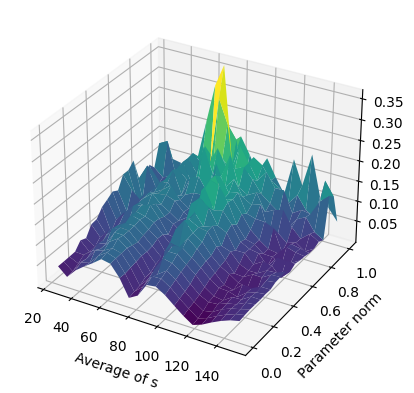

In [ ]:
result = np.max(np.abs(exact_solution_evaluated- DPDE_solution.detach().cpu().numpy() ),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s_plot_mesh, p_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('Average of s')
ax.set_ylabel('Parameter norm')
plt.show()



In [ ]:
x = np.random.uniform(-1,1,size=[1000,dimension_total])
approximate = solve.solver(torch.tensor(x).to(torch.float32).to(device)).detach().cpu().numpy()
exact_value = np.zeros((1000,))


rel_implied = np.zeros((1000,))


time = transform_to_time(x[:,0:1])
stock_price  =transform_to_logprice(x[:, 1: dimension_state + 1])
covariance = transform_to_volatility(x[: ,dimension_state + 1 : dimension_state + 2 ])
corr = transform_to_correlation(x[: ,dimension_state + 2 : dimension_state + 3])
r = transform_to_riskfree_rate(x[:, dimension_state + 3 :dimension_state + 4])

for i in range(1000) :


  exact_value[i] = geometric_option_pricing(time[i],stock_price[i].reshape(1,dimension_state),r[i],100,covariance[i]**2,corr[i],dimension_state)[0,0]
  beta = covariance[i]**2 /2*(1-1.0/dimension_state)*(1-corr[i])
  lowerbound =np.maximum(np.exp(np.mean(stock_price[i]))*np.exp(-beta * time[i]) - strike_price * np.exp( -r[i] * time[i]),0)

  if exact_value[i] - lowerbound > 0.5 :

    est = calculate_implied_volatility(np.exp(np.mean(stock_price[i]))*np.exp(-beta * time[i]),100,r[i],time[i],approximate[i,0])
    exact = calculate_implied_volatility(np.exp(np.mean(stock_price[i]))*np.exp(-beta * time[i]),100,r[i],time[i],exact_value[i])
    rel_implied[i] = (est - exact)/exact
  else  :
    rel_implied[i] = None








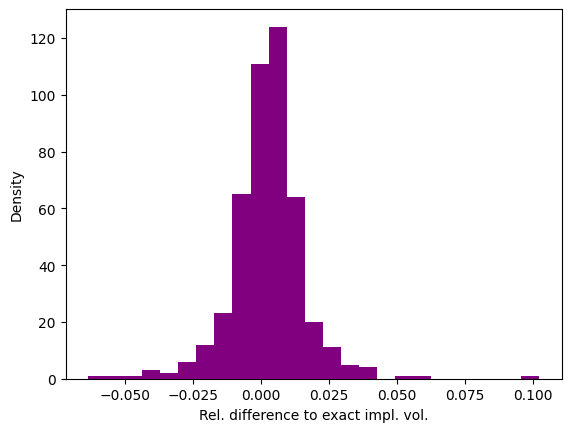

In [ ]:
plt.hist(rel_implied[rel_implied < 0.5],color = 'purple' , bins=25);
plt.xlabel('Rel. difference to exact impl. vol.')
plt.ylabel('Density')
plt.show()

### Dim 5

In [ ]:
dimension_state = 5
dimension_parameter = 3
dimension_total = 1 + dimension_state + dimension_parameter


device = torch.device('cuda')
solve = PDESolvergeometric(90,0.001,dimension_total)
solve.solve(5000,1000,device)

1
tensor(8.3961, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(8.1277, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(8.1833, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(7.1417, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(6.5812, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(6.8561, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(6.3402, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(5.9226, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(5.6052, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(5.2354, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(5.6980, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(5.4398, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(5.5358, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(5.6938, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(5.0902, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(5.1651, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(5.3610, device='cuda:0', grad_fn=<AddBackward0>)
18
ten

KeyboardInterrupt: ignored

In [ ]:
samples_s,p,s_plot_mesh, p_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartying_parameter(dim = 5)
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(4410,dimension_total)).to(device).to(torch.float32)).reshape(
    21, 21,10)


w = np.array((dimension_state,1)) / dimension_state



samples_s =samples_s
covariance = transform_to_volatility(p[: ,:,:,0 : 1])
corr = transform_to_correlation(p[: ,:,:,1 : 2])
r =  transform_to_riskfree_rate(p[:, :,:,2 : 3 ])


exact_solution_evaluated = np.zeros((21,21 ,10))
for i,(s,t) in enumerate(zip(s_plot_mesh, p_plot_mesh)):
  for j in range(len(s)):
    for k in range(10):

        exact_solution_evaluated[i,j,k] = geometric_option_pricing(4,np.log(samples_s[i,j,k].reshape(1,dimension_state)) ,r[i,j,k],100,covariance[i,j,k]**2,corr[i,j,k],dimension_state)[0,0]

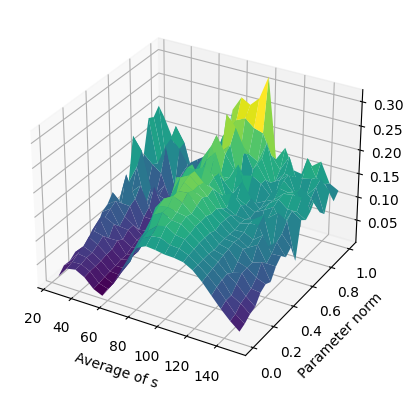

In [ ]:
result = np.max(np.abs(exact_solution_evaluated- DPDE_solution.detach().cpu().numpy() ),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s_plot_mesh, p_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('Average of s')
ax.set_ylabel('Parameter norm')
plt.show()



In [ ]:
x = np.random.uniform(-1,1,size=[1000,dimension_total])
approximate = solve.solver(torch.tensor(x).to(torch.float32).to(device)).detach().cpu().numpy()
exact_value = np.zeros((1000,))


rel_implied = np.zeros((1000,))


time = transform_to_time(x[:,0:1])
stock_price  =transform_to_logprice(x[:, 1: dimension_state + 1])
covariance = transform_to_volatility(x[: ,dimension_state + 1 : dimension_state + 2 ])
corr = transform_to_correlation(x[: ,dimension_state + 2 : dimension_state + 3])
r = transform_to_riskfree_rate(x[:, dimension_state + 3 :dimension_state + 4])

for i in range(1000) :


  exact_value[i] = geometric_option_pricing(time[i],stock_price[i].reshape(1,dimension_state),r[i],100,covariance[i]**2,corr[i],dimension_state)[0,0]
  beta = covariance[i]**2 /2*(1-1.0/dimension_state)*(1-corr[i])
  lowerbound =np.maximum(np.exp(np.mean(stock_price[i]))*np.exp(-beta * time[i]) - strike_price * np.exp( -r[i] * time[i]),0)

  if exact_value[i] - lowerbound > 0.5 :

    est = calculate_implied_volatility(np.exp(np.mean(stock_price[i]))*np.exp(-beta * time[i]),100,r[i],time[i],approximate[i,0])
    exact = calculate_implied_volatility(np.exp(np.mean(stock_price[i]))*np.exp(-beta * time[i]),100,r[i],time[i],exact_value[i])
    rel_implied[i] = (est - exact)/exact
  else  :
    rel_implied[i] = None








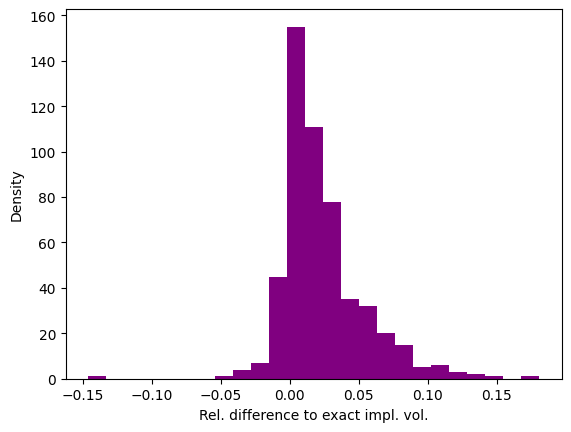

In [ ]:
plt.hist(rel_implied[rel_implied < 0.5],color = 'purple' , bins=25);
plt.xlabel('Rel. difference to exact impl. vol.')
plt.ylabel('Density')
plt.show()

### Dim 8

In [ ]:
dimension_state = 8
dimension_parameter = 3
dimension_total = 1 + dimension_state + dimension_parameter


device = torch.device('cuda')
solve = PDESolvergeometric(90,0.001,dimension_total)
solve.solve(5000,1000,device)

1
tensor(10.7215, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(9.6386, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(10.1354, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(9.3087, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(9.1233, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(8.4140, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(8.0448, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(7.6162, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(7.4780, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(6.6537, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(6.9459, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(5.8464, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(6.2242, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(6.1428, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(6.1404, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(6.3947, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(6.0563, device='cuda:0', grad_fn=<AddBackward0>)
18
t

KeyboardInterrupt: ignored

In [ ]:
samples_s,p,s_plot_mesh, p_plot_mesh, x_plot_normalised = get_points_for_plot_at_vartying_parameter(dim = 8)
DPDE_solution = solve.solver(torch.tensor(x_plot_normalised.reshape(4410,dimension_total)).to(device).to(torch.float32)).reshape(
    21, 21,10)


w = np.array((dimension_state,1)) / dimension_state



samples_s =samples_s
covariance = transform_to_volatility(p[: ,:,:,0 : 1])
corr = transform_to_correlation(p[: ,:,:,1 : 2])
r =  transform_to_riskfree_rate(p[:, :,:,2 : 3 ])


exact_solution_evaluated = np.zeros((21,21 ,10))
for i,(s,t) in enumerate(zip(s_plot_mesh, p_plot_mesh)):
  for j in range(len(s)):
    for k in range(10):

        exact_solution_evaluated[i,j,k] = geometric_option_pricing(4,np.log(samples_s[i,j,k].reshape(1,dimension_state)) ,r[i,j,k],100,covariance[i,j,k]**2,corr[i,j,k],dimension_state)[0,0]

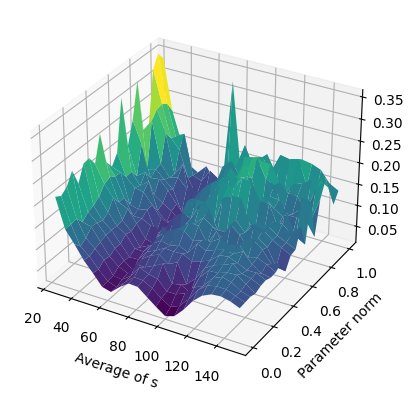

In [ ]:
result = np.max(np.abs(exact_solution_evaluated- DPDE_solution.detach().cpu().numpy() ),2)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s_plot_mesh, p_plot_mesh, result, cmap='viridis')
ax.set_title('')
ax.set_xlabel('Average of s')
ax.set_ylabel('Parameter norm')
plt.show()



In [ ]:
x = np.random.uniform(-1,1,size=[1000,dimension_total])
approximate = solve.solver(torch.tensor(x).to(torch.float32).to(device)).detach().cpu().numpy()
exact_value = np.zeros((1000,))


rel_implied = np.zeros((1000,))


time = transform_to_time(x[:,0:1])
stock_price  =transform_to_logprice(x[:, 1: dimension_state + 1])
covariance = transform_to_volatility(x[: ,dimension_state + 1 : dimension_state + 2 ])
corr = transform_to_correlation(x[: ,dimension_state + 2 : dimension_state + 3])
r = transform_to_riskfree_rate(x[:, dimension_state + 3 :dimension_state + 4])

for i in range(1000) :


  exact_value[i] = geometric_option_pricing(time[i],stock_price[i].reshape(1,dimension_state),r[i],100,covariance[i]**2,corr[i],dimension_state)[0,0]
  beta = covariance[i]**2 /2*(1-1.0/dimension_state)*(1-corr[i])
  lowerbound =np.maximum(np.exp(np.mean(stock_price[i]))*np.exp(-beta * time[i]) - strike_price * np.exp( -r[i] * time[i]),0)

  if exact_value[i] - lowerbound > 0.5 :

    est = calculate_implied_volatility(np.exp(np.mean(stock_price[i]))*np.exp(-beta * time[i]),100,r[i],time[i],approximate[i,0])
    exact = calculate_implied_volatility(np.exp(np.mean(stock_price[i]))*np.exp(-beta * time[i]),100,r[i],time[i],exact_value[i])
    rel_implied[i] = (est - exact)/exact
  else  :
    rel_implied[i] = None








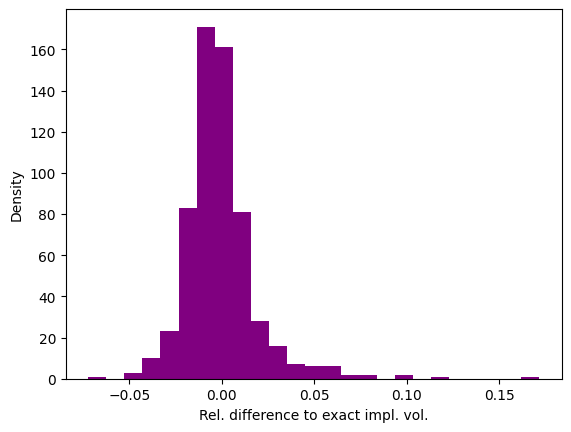

In [ ]:
plt.hist(rel_implied[rel_implied < 0.5],color = 'purple' , bins=25);
plt.xlabel('Rel. difference to exact impl. vol.')
plt.ylabel('Density')
plt.show()

# Computing  Sensivity with model and evaluting its performance

In [ ]:
dimension_state = 2
dimension_parameter = 3
dimension_total = 1 + dimension_state + dimension_parameter


device = torch.device('cuda')
solve = PDESolvergeometric(90,0.0005,dimension_total)
solve.solve(5000,1000,device)

1
tensor(6.5777, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(6.8826, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(6.2414, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(5.6016, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(6.2996, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(5.9148, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(5.7606, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(5.9739, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(5.6629, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(5.2594, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(4.4509, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(5.2410, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(4.8371, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(4.9638, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(5.1320, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(5.1517, device='cuda:0', grad_fn=<AddBackward0>)
17
tensor(4.9599, device='cuda:0', grad_fn=<AddBackward0>)
18
ten

KeyboardInterrupt: ignored

In [ ]:
s1_plot_mesh, s2_plot_mesh, x_plot_normalised = get_points_for_plot_at_fixed_time()

x_plot_normalised_grad = torch.tensor(x_plot_normalised,requires_grad=True).to(device).to(torch.float32)
DPDE_solution = solve.solver(x_plot_normalised_grad)
first_derivative = autograd.grad(DPDE_solution.sum(), x_plot_normalised_grad, create_graph=True)[0]
der_to_first_approx = (first_derivative[:,1] * diff_dx).reshape(21,21)
der_to_vol_approx = (first_derivative[:,3] * diff_dv).reshape(21,21)


In [ ]:
volatility = torch.tensor(transform_to_volatility(x_plot_normalised[:, dimension_state + 1:dimension_state + 2]),requires_grad=True)
correlation = torch.tensor(transform_to_correlation(x_plot_normalised[:, dimension_state + 2:dimension_state + 3]))
riskfree =  torch.tensor(transform_to_riskfree_rate(x_plot_normalised[:, dimension_state + 3 :dimension_state + 4]))
inputs_t = torch.tensor(transform_to_time(x_plot_normalised[:,0:1]))
x = torch.tensor(transform_to_logprice(x_plot_normalised[:,1:dimension_state+1]),requires_grad=True)








In [ ]:
def geometric_option_pricing_torch(t,x,r,k,var , cor,dim):
  normal = torch.distributions.normal.Normal(0 , 1)
  var_bar = var/dim *(1+(dim-1)*cor)
  q = (var - var_bar)/2
  x_bar = torch.mean(x,1 , keepdims=True)
  d1 = (x_bar - np.log(k) + r*t - q*t + var_bar/2 *t)/(torch.sqrt(t*var_bar))
  d2 = d1 - torch.sqrt(var_bar * t)
  option_price = normal.cdf(d1) * torch.exp(-1 * q * t + x_bar) - normal.cdf(d2)*k*torch.exp(-r * t)
  return option_price

In [ ]:
exact_solution_evaluated = geometric_option_pricing_torch(inputs_t , x, riskfree , 100,volatility**2 , correlation,dimension_state)


der_to_vol_exact = autograd.grad(exact_solution_evaluated.sum(), volatility)[0].reshape(21,21)


exact_solution_evaluated = geometric_option_pricing_torch(inputs_t , x, riskfree , 100,volatility**2 , correlation,dimension_state)

der_to_first_exact = autograd.grad(exact_solution_evaluated.sum(), x)[0]
der_to_first_exact = der_to_first_exact[: , 0].reshape(21,21)




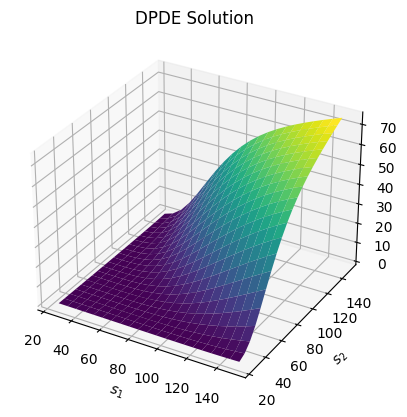

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, der_to_first_approx.detach().cpu(), cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

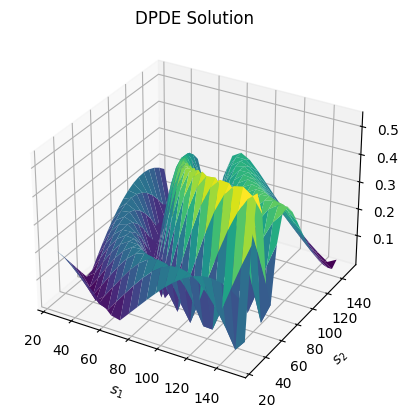

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, np.abs(der_to_first_approx.detach().cpu() - der_to_first_exact.detach().cpu()) , cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

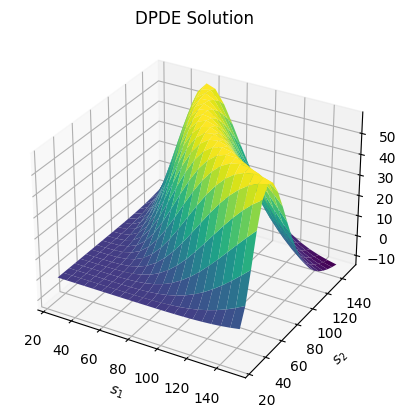

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, der_to_vol_exact.detach().cpu(), cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

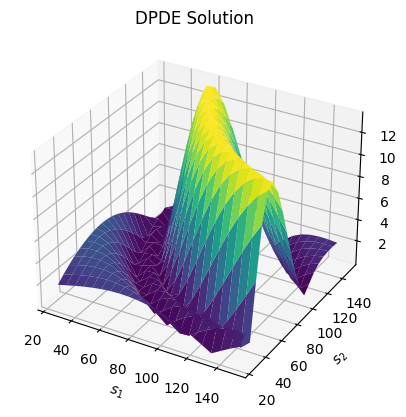

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, np.abs(der_to_vol_approx.detach().cpu() - der_to_vol_exact.detach().cpu()) , cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

In [ ]:
def basket_option_montecalro_geometric(t,S,CovMatrix,K,r, dim):
  W = cp.random.multivariate_normal(mean = np.zeros(dim) , cov = t*CovMatrix, size = 100000000)

  Sn =  cp.array(cp.exp((r- cp.diagonal(CovMatrix)/2)*t + W)) * 100
  payoff = cp.maximum(cp.exp(cp.mean(cp.log(Sn),1 )) - K , 0)
  return cp.mean(payoff) * cp.exp(-r * t)

cov = cp.array([[0.01 , 0.005],[0.005,0.01]])
S = cp.array([100,100]).reshape(1,2)

basket_option_montecalro_geometric(4,S , cov,100,0.2,2)

array(54.56697539)